# Impact of Macro-Economic Indicators on Banking Sector Resilience

### Data 690: Financial Data Science
#### Prof. Abdullah Karasan
#### Presented by:
#### - Sai Manvitha Nadella (FT44056)
#### - Sampath Kumar Rayavarapu (TW34813)

## Introduction:

The project focuses on analyzing the financial resilience of the banking sector using macroeconomic indicators and stock price performance during crisis periods. 

The banking sector's stability is crucial for economic health, and understanding how external shocks, such as inflation or market downturns, influence stock performance can offer actionable insights.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf  # For fetching financial data
from fredapi import Fred  # For accessing macroeconomic data
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced visualizations
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  # For stationarity testing
from statsmodels.tsa.arima.model import ARIMA  # For time series modeling
from sklearn.linear_model import LinearRegression  # For CAPM beta calculation
from scipy.stats import zscore  # For standardizing data
from scipy.optimize import minimize  # For portfolio optimization

# Set up FRED API key
fred_api_key = "78b14ec6ba46f484b94db43694468bb1"
fred = Fred(api_key=fred_api_key)

## Data Collection
#### Fetch Stock Data

In [2]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch stock price data for a given list of tickers using Yahoo Finance.
    """
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Define tickers for bank stocks
bank_tickers = ["JPM", "BAC", "C", "WFC", "GS", "^GSPC"]

# Fetch stock data
stock_data = fetch_stock_data(bank_tickers, "2015-01-01", "2024-01-01")
print(stock_data.head())


[*********************100%***********************]  6 of 6 completed

Ticker                           BAC          C          GS        JPM  \
Date                                                                     
2015-01-02 00:00:00+00:00  14.532612  41.534019  159.565155  47.709976   
2015-01-05 00:00:00+00:00  14.110435  40.225079  154.583130  46.228813   
2015-01-06 00:00:00+00:00  13.688260  38.808971  151.455963  45.030148   
2015-01-07 00:00:00+00:00  13.753208  39.168743  153.713028  45.098862   
2015-01-08 00:00:00+00:00  14.037365  39.758144  156.167145  46.106655   

Ticker                           WFC        ^GSPC  
Date                                               
2015-01-02 00:00:00+00:00  41.032391  2058.199951  
2015-01-05 00:00:00+00:00  39.907192  2020.579956  
2015-01-06 00:00:00+00:00  39.074532  2002.609985  
2015-01-07 00:00:00+00:00  39.307083  2025.900024  
2015-01-08 00:00:00+00:00  40.177235  2062.139893  


#### Fetch Macroeconomic Data

In [3]:
def fetch_macro_data(indicators, start_date, end_date):
    """
    Fetch macroeconomic indicator data using the FRED API.
    """
    macro_data = {}
    for name, code in indicators.items():
        macro_data[name] = fred.get_series(code, start_date, end_date)
    return pd.DataFrame(macro_data)

# Define macroeconomic indicators
macro_indicators = {"CPI": "CPIAUCSL", "Unemployment": "UNRATE", "Interest Rate": "FEDFUNDS"}

# Fetch macroeconomic data
macro_data = fetch_macro_data(macro_indicators, "2015-01-01", "2024-01-01")
print(macro_data.head())


                CPI  Unemployment  Interest Rate
2015-01-01  234.747           5.7           0.11
2015-02-01  235.342           5.5           0.11
2015-03-01  235.976           5.4           0.11
2015-04-01  236.222           5.4           0.12
2015-05-01  237.001           5.6           0.12


## Data Cleaning and Preprocessing

#### Handling Missing Values

In [4]:
# Forward fill missing values for stock and macroeconomic data
stock_data = stock_data.fillna(method="ffill")
macro_data = macro_data.fillna(method="ffill")


/var/folders/lg/55c_rby54bx9w4_nnk4cl9jc0000gn/T/ipykernel_85775/2080026122.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method="ffill")
/var/folders/lg/55c_rby54bx9w4_nnk4cl9jc0000gn/T/ipykernel_85775/2080026122.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data = macro_data.fillna(method="ffill")


#### Calculating Stock Returns

In [5]:
# Log-transform stock prices to calculate daily returns
stock_returns = np.log(stock_data / stock_data.shift(1)).dropna()
print(stock_returns.head())


Ticker                          BAC         C        GS       JPM       WFC  \
Date                                                                          
2015-01-05 00:00:00+00:00 -0.029481 -0.032022 -0.031720 -0.031537 -0.027805   
2015-01-06 00:00:00+00:00 -0.030376 -0.035839 -0.020437 -0.026271 -0.021086   
2015-01-07 00:00:00+00:00  0.004734  0.009228  0.014792  0.001525  0.005934   
2015-01-08 00:00:00+00:00  0.020451  0.014936  0.015839  0.022100  0.021896   
2015-01-09 00:00:00+00:00 -0.018092 -0.022587 -0.015465 -0.017540 -0.016566   

Ticker                        ^GSPC  
Date                                 
2015-01-05 00:00:00+00:00 -0.018447  
2015-01-06 00:00:00+00:00 -0.008933  
2015-01-07 00:00:00+00:00  0.011563  
2015-01-08 00:00:00+00:00  0.017730  
2015-01-09 00:00:00+00:00 -0.008439  


#### Aligning data

In [6]:
# Convert stock_returns index to timezone-naive
stock_returns.index = stock_returns.index.tz_localize(None)

# Convert macro_data index to timezone-naive
macro_data.index = macro_data.index.tz_localize(None)

# Align stock returns and macroeconomic data on common dates
aligned_data = pd.concat([stock_returns, macro_data], axis=1).dropna()
print(aligned_data.head())

                 BAC         C        GS       JPM       WFC     ^GSPC  \
2015-04-01  0.001299  0.001939  0.022410 -0.003829 -0.008492 -0.003973   
2015-05-01  0.011236  0.008218  0.005635  0.005517  0.001632  0.010864   
2015-06-01  0.003026  0.006819  0.007826  0.004550  0.001429  0.002057   
2015-07-01  0.011683  0.007933  0.005493  0.011079  0.011843  0.006912   
2015-09-01 -0.047628 -0.048659 -0.034963 -0.042220 -0.044869 -0.030023   

                CPI  Unemployment  Interest Rate  
2015-04-01  236.222           5.4           0.12  
2015-05-01  237.001           5.6           0.12  
2015-06-01  237.657           5.3           0.13  
2015-07-01  238.034           5.2           0.13  
2015-09-01  237.498           5.0           0.14  


## Exploratory Data Analysis

#### Compute Annualized Return and Risk

        Annualized Return  Annualized Risk (Volatility)
Ticker                                                 
BAC              0.090765                      0.318828
C                0.019749                      0.335212
GS               0.095639                      0.291625
JPM              0.138934                      0.277298
WFC              0.017355                      0.317442
^GSPC            0.093593                      0.183809


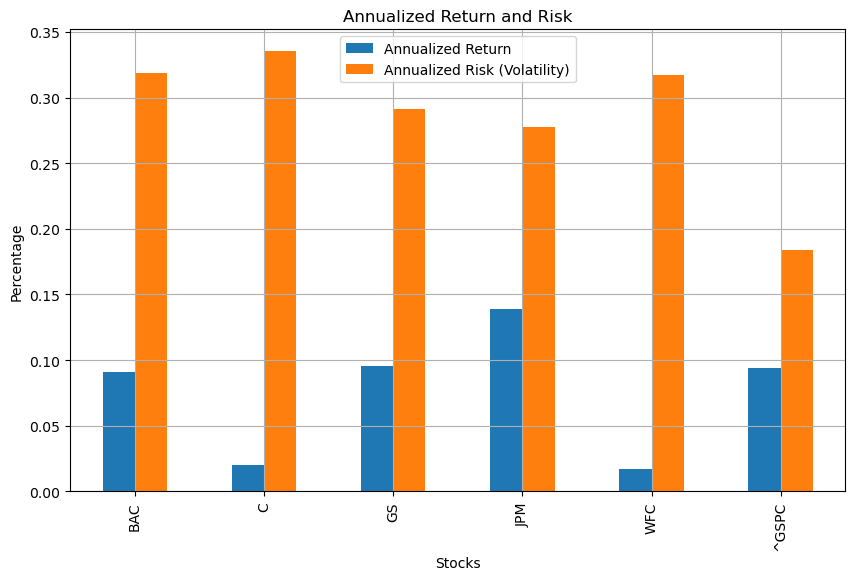

In [7]:
# Compute annualized return and risk (volatility)
annualized_return = stock_returns.mean() * 252  # 252 trading days in a year
annualized_risk = stock_returns.std() * np.sqrt(252)

# Display the results
financial_metrics = pd.DataFrame({
    "Annualized Return": annualized_return,
    "Annualized Risk (Volatility)": annualized_risk
})
print(financial_metrics)

# Bar plot for annualized return and risk
financial_metrics.plot(kind="bar", figsize=(10, 6), title="Annualized Return and Risk")
plt.ylabel("Percentage")
plt.xlabel("Stocks")
plt.grid()
plt.show()


The bar chart compares the annualized return and risk (volatility) of selected banking stocks, including JPMorgan Chase, Bank of America, Citigroup, Wells Fargo, Goldman Sachs, and the S&P 500 index. The chart reveals that while some stocks, such as JPMorgan Chase, deliver higher returns, they also exhibit moderate volatility. Conversely, Citigroup and Wells Fargo show lower returns accompanied by higher volatility, highlighting the trade-off between risk and return. The S&P 500 index, as a benchmark, balances moderate risk with a relatively stable return, serving as a baseline for portfolio evaluation.

#### Covariance Matrix

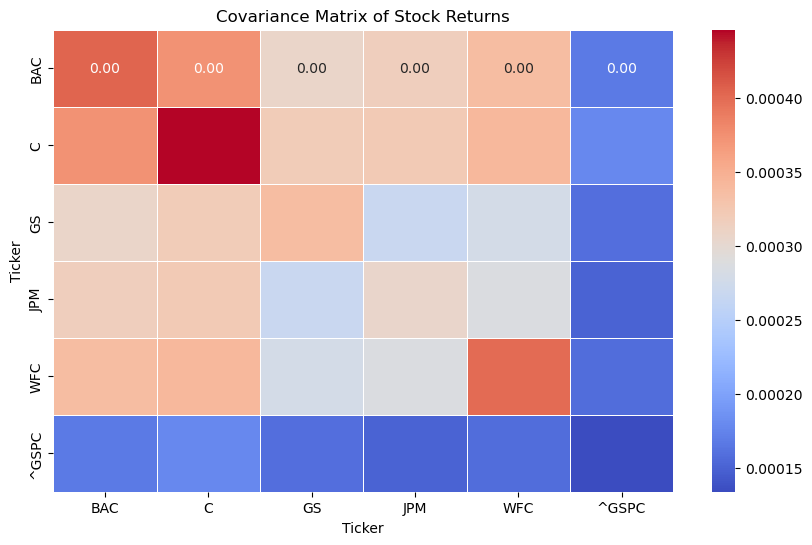

In [8]:
# Compute covariance matrix of stock returns
cov_matrix = stock_returns.cov()

# Display covariance matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Covariance Matrix of Stock Returns")
plt.show()


The covariance matrix heatmap displays the degree of co-movement between the returns of banking stocks and the S&P 500 index. A higher covariance between certain stocks, such as JPMorgan Chase and Goldman Sachs, suggests that these stocks are likely to move in the same direction, making portfolio diversification challenging. The low covariance values between banking stocks and macroeconomic indicators like CPI and interest rates suggest limited direct influence, warranting further regression analysis to explore indirect relationships.

#### Visualizing Stock Prices

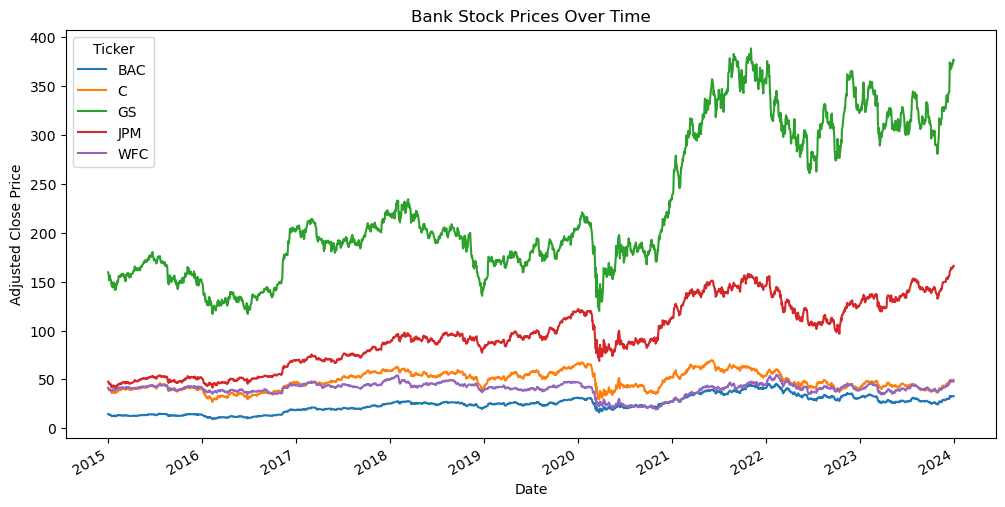

In [9]:
# Exclude the last column using .iloc
stock_data_excluded = stock_data.iloc[:, :-1]

# Plot the data excluding the last column
stock_data_excluded.plot(figsize=(12, 6), title="Bank Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.show()

The line chart visualizes the adjusted close prices of banking stocks over time. A notable trend is the impact of major economic events, such as the COVID-19 pandemic, where stock prices experienced significant fluctuations. For instance, JPMorgan Chase showed resilience and recovery post-2020, while other banks exhibited slower rebounds. The chart highlights the importance of analyzing temporal trends and the influence of external macroeconomic conditions on stock performance.

#### Correlation Heatmap

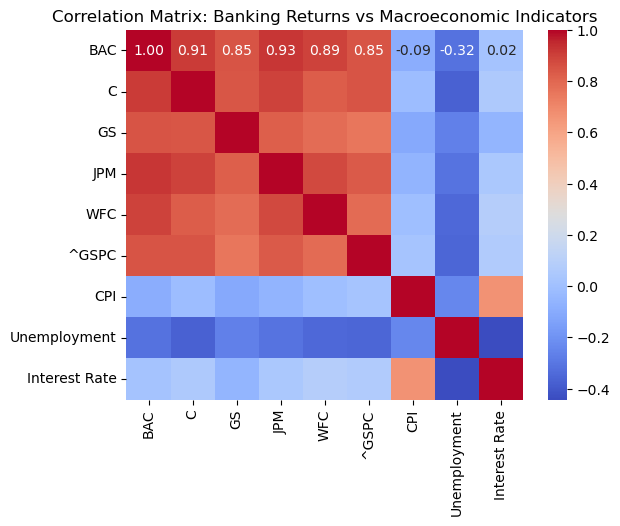

In [10]:
sns.heatmap(aligned_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Banking Returns vs Macroeconomic Indicators")
plt.show()


The correlation matrix heatmap quantifies the relationships between banking stock returns and macroeconomic indicators. Strong positive correlations among banking stocks indicate synchronized movement, reducing diversification benefits. The weak or negative correlations with macroeconomic indicators like CPI and unemployment rates suggest that these factors may influence stock performance indirectly, emphasizing the need for regression and causality analysis.

#### Rolling Statistics: Moving Average and Standard Deviation

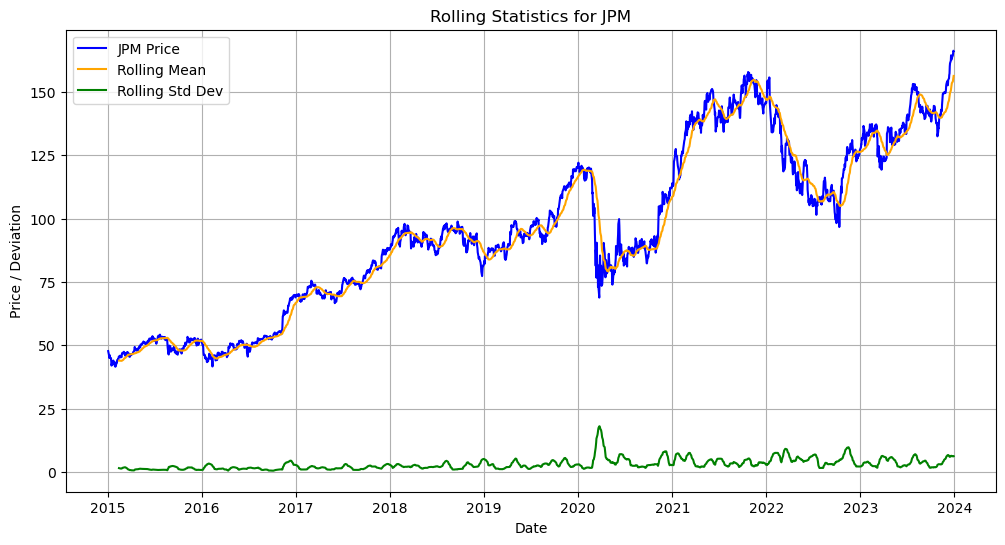

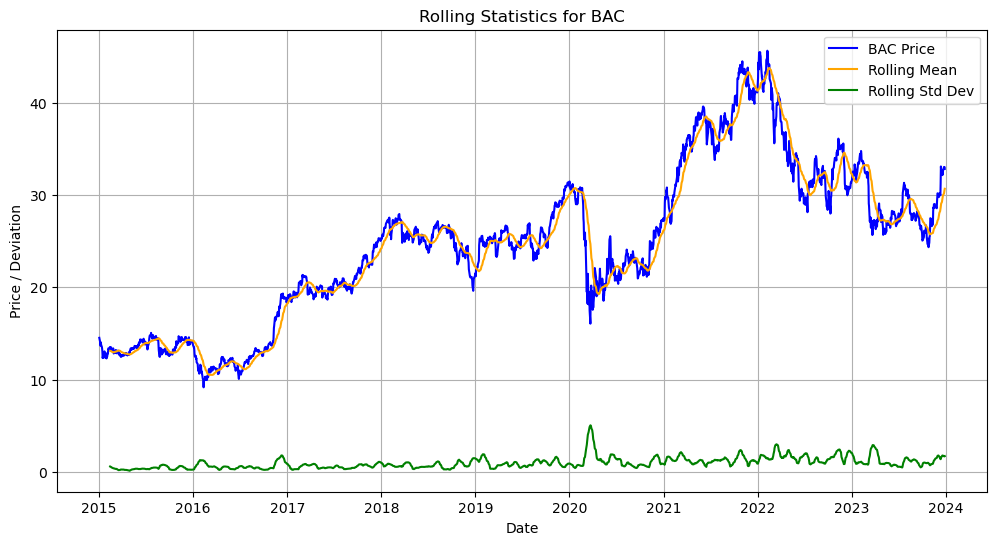

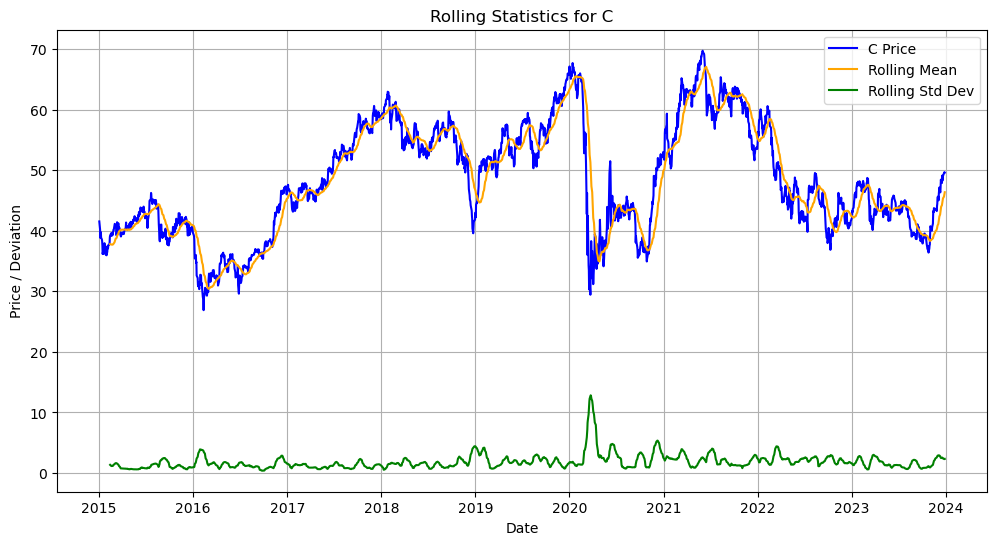

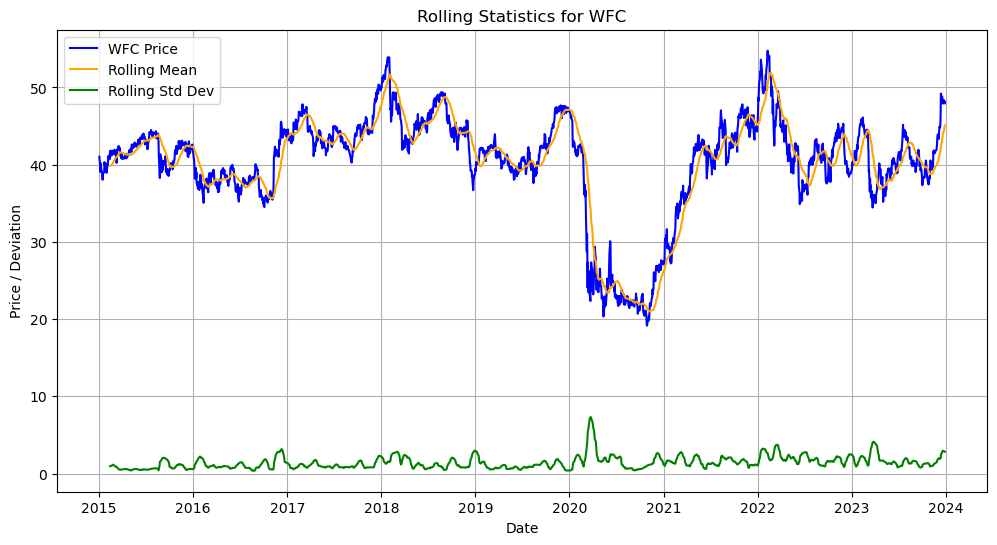

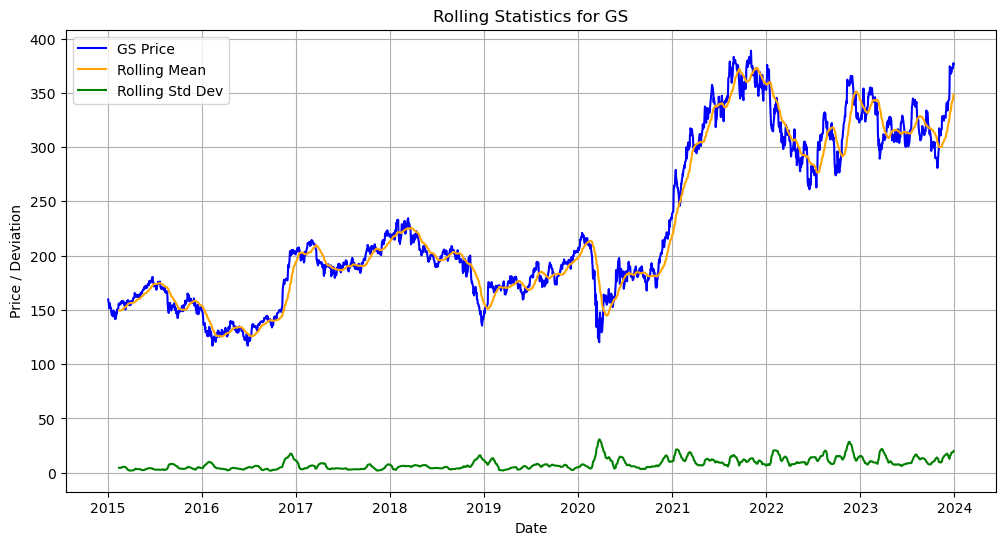

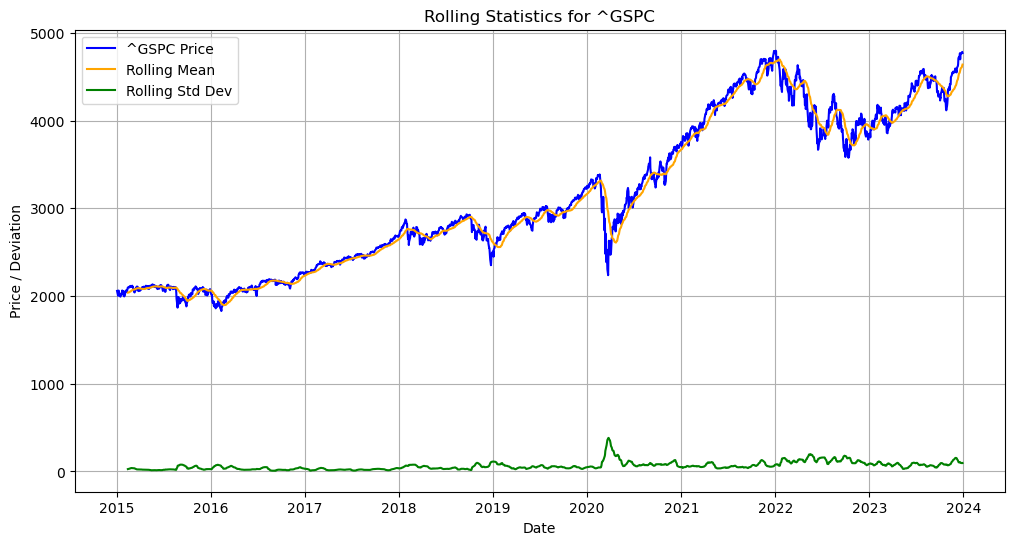

In [11]:
# Plot rolling mean and standard deviation for each stock
window_size = 30  # 30-day rolling window
for ticker in bank_tickers:
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data[ticker], label=f"{ticker} Price", color="blue")
    plt.plot(stock_data[ticker].rolling(window=window_size).mean(), label="Rolling Mean", color="orange")
    plt.plot(stock_data[ticker].rolling(window=window_size).std(), label="Rolling Std Dev", color="green")
    plt.title(f"Rolling Statistics for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price / Deviation")
    plt.legend()
    plt.grid()
    plt.show()


The rolling statistics graph for JPMorgan Chase shows the stock's price trend along with its rolling mean and rolling standard deviation over time. The rolling mean captures the overall trend, while the rolling standard deviation reflects volatility. The spike in volatility during the 2020 COVID-19 period highlights the stock's sensitivity to market disruptions. The graph underscores the importance of tracking rolling metrics to monitor stability and risk over time.

#### Distribution of Stock Returns

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


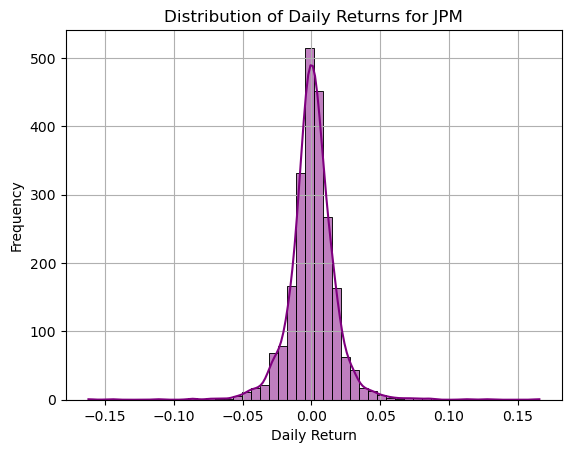

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


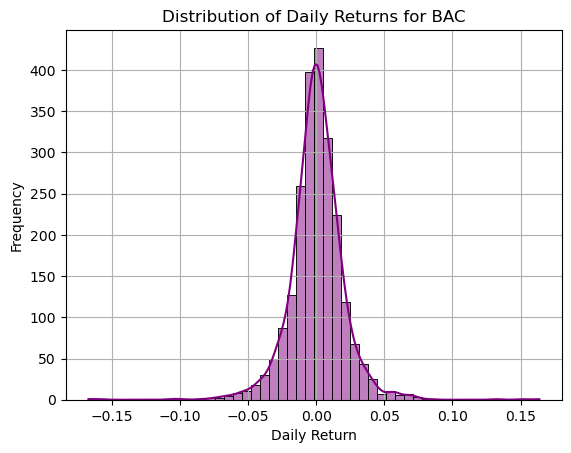

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


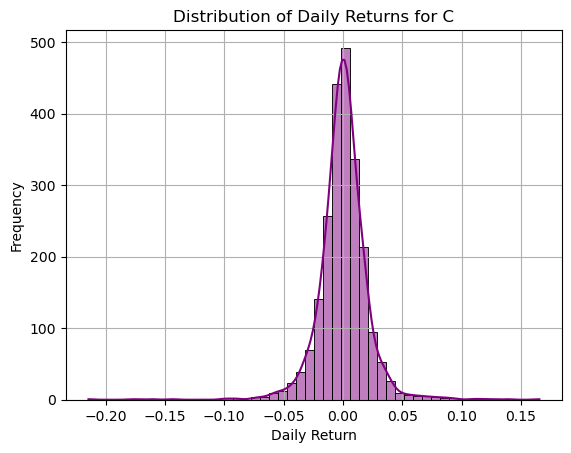

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


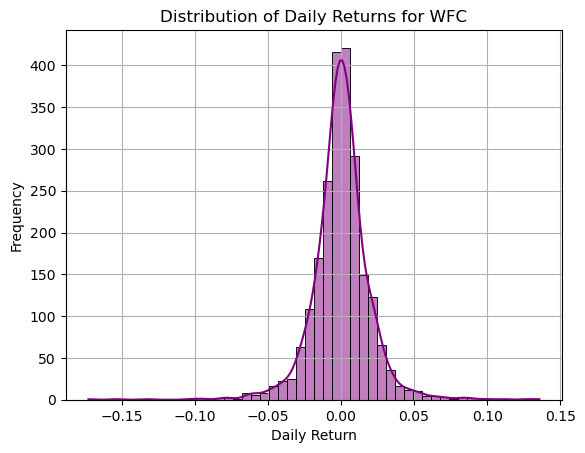

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


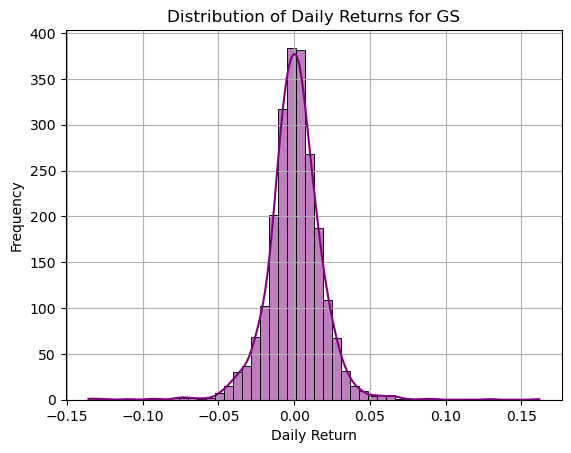

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


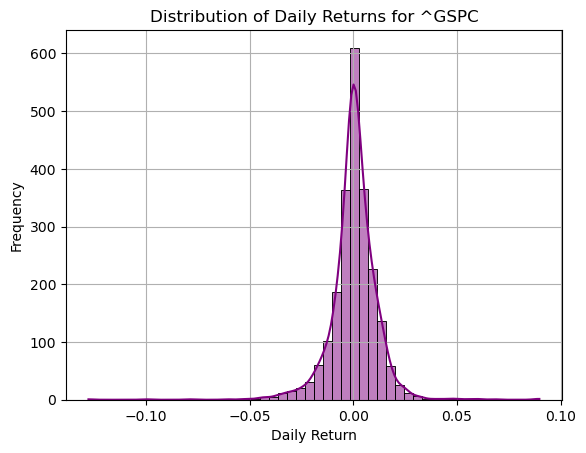

In [12]:
# Plot the distribution of stock returns for each bank
for ticker in bank_tickers:
    sns.histplot(stock_returns[ticker], kde=True, bins=50, color="purple")
    plt.title(f"Distribution of Daily Returns for {ticker}")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

The distribution of stock returns presented in the visualizations reveals several key insights about the behavior of daily returns for the selected stocks (BAC, GS, WFC, C, ^GSPC, and JPM). All distributions exhibit a bell-shaped curve, indicative of a tendency toward a normal distribution. This is a common characteristic in financial data due to the Central Limit Theorem, particularly for short time intervals such as daily returns. The approximate symmetry around the mean suggests that there is no significant skewness, implying an absence of extreme directional bias in the returns. Such symmetry reflects balanced market behavior, with positive and negative returns being equally probable over time.

The distributions also display some evidence of "fat tails," which are characteristic of leptokurtic behavior. This suggests that while most returns are concentrated near the mean, there are occasional extreme events or outliers that significantly deviate from the mean. These outliers are critical for financial analysis, as they represent high-impact market events that can substantially influence portfolios. Most of the daily returns are tightly clustered around zero, indicating that stock prices generally experience only small changes on a daily basis. This behavior aligns with the efficient market hypothesis, where drastic daily price fluctuations are rare and largely driven by external shocks.

A comparison of the distributions across the stocks and the benchmark index (^GSPC) highlights subtle differences in volatility and risk profiles. The benchmark (^GSPC) exhibits a slightly tighter clustering around zero, suggesting lower volatility compared to individual stocks. This aligns with the diversified nature of indices, which reduces overall risk through the inclusion of a broader range of assets. Such findings are crucial for further statistical modeling and risk analysis. The normal-like behavior supports the application of methods like Value at Risk (VaR) for risk estimation, while the occasional outliers emphasize the importance of robust risk management strategies. Overall, these distributions underscore the dynamic yet balanced nature of daily stock market movements, providing a strong foundation for analyzing market performance and volatility.

#### Macroeconomic Data Trends

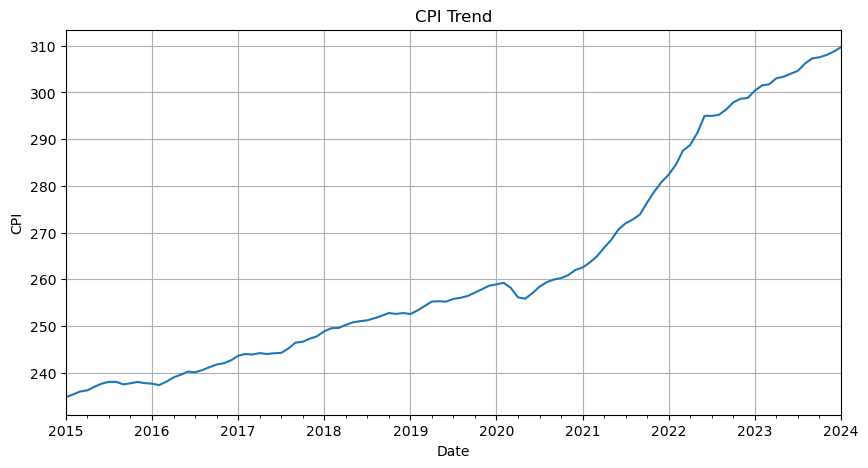

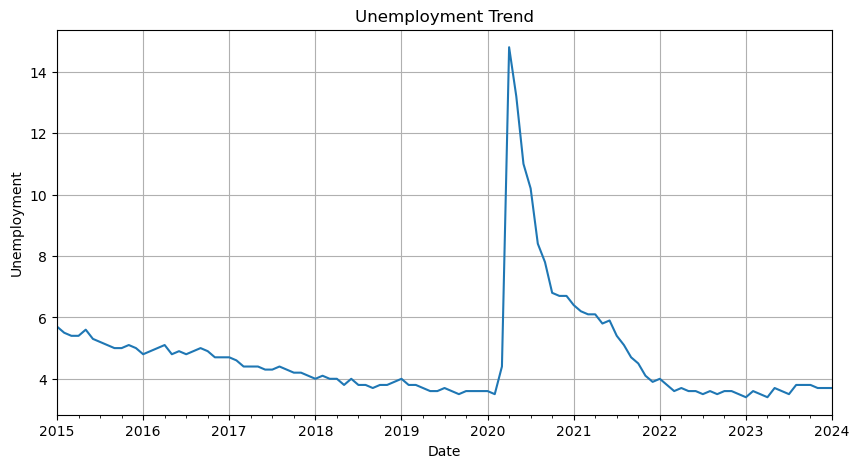

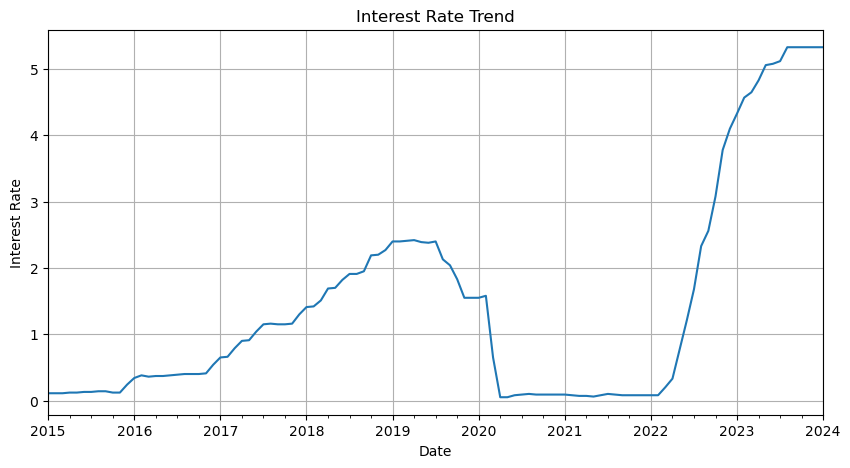

In [13]:
# Plot each macroeconomic indicator
for indicator in macro_indicators.keys():
    macro_data[indicator].plot(figsize=(10, 5), title=f"{indicator} Trend")
    plt.xlabel("Date")
    plt.ylabel(indicator)
    plt.grid()
    plt.show()

The individual line charts for macroeconomic indicators—CPI, unemployment rate, and interest rates—depict their trends over time. The steady increase in CPI reflects inflationary pressures, while the unemployment rate shows a sharp spike during the 2020 pandemic, followed by gradual recovery. Interest rates remain relatively stable but exhibit minor fluctuations, aligning with monetary policy changes. 

The unemployment trend demonstrates a stable decrease from 2015 to early 2020, followed by a sharp spike during the COVID-19 pandemic. This spike corresponds to the economic disruptions caused by lockdowns and reduced business activity. Post-2020, the unemployment rate steadily declines as economies recover, reaching pre-pandemic levels by 2023.


The interest rate trend exhibits a gradual increase from 2015 to 2019, indicating tightening monetary policy. However, there is a significant drop in 2020 as central banks lowered rates to stimulate the economy during the pandemic. The sharp rise in 2022-2023 reflects aggressive rate hikes aimed at combating inflation.

#### Comparing Stock Performance During Crises

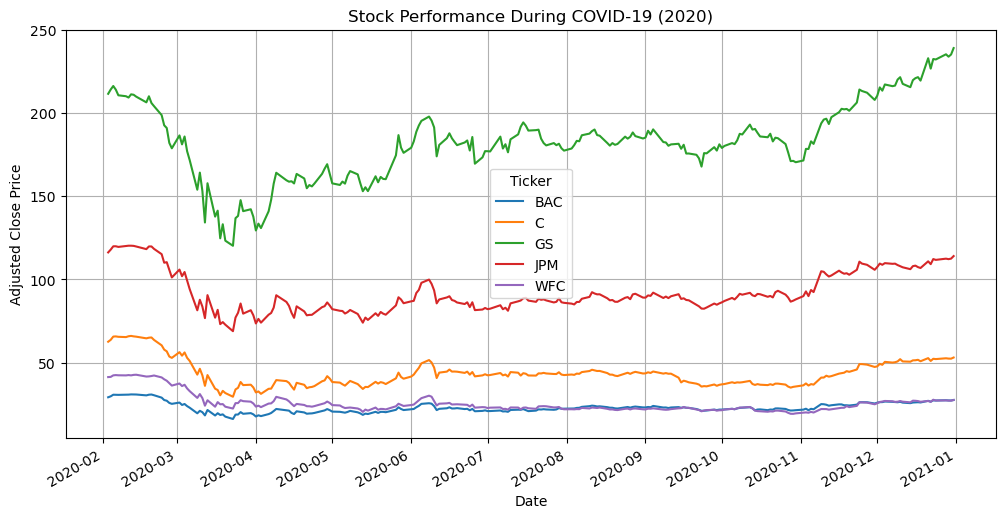

In [14]:
# Highlighting crisis periods (e.g., COVID-19)
crisis_period = stock_data.loc["2020-02-01":"2020-12-31"]

# Exclude the last column using .iloc
crisis_period_excluded = crisis_period.iloc[:, :-1]

# Plot the data excluding the last column
crisis_period_excluded.plot(figsize=(12, 6), title="Stock Performance During COVID-19 (2020)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.grid()
plt.show()

The line plot during the COVID-19 crisis (2020) captures how different bank stocks responded to the economic turmoil. All stocks experienced significant declines early in the year, but their recovery patterns vary. For instance, JPM and GS recovered strongly, reflecting their robust fundamentals, while BAC and WFC showed slower rebounds. This analysis demonstrates the resilience of certain banks during crises and highlights the potential risks of investing in less resilient stocks.

#### Scatter Plot of Stock Returns vs. Macroeconomic Indicators

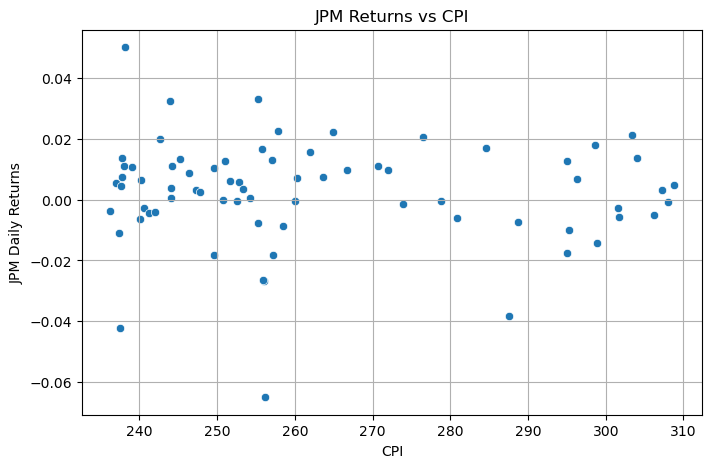

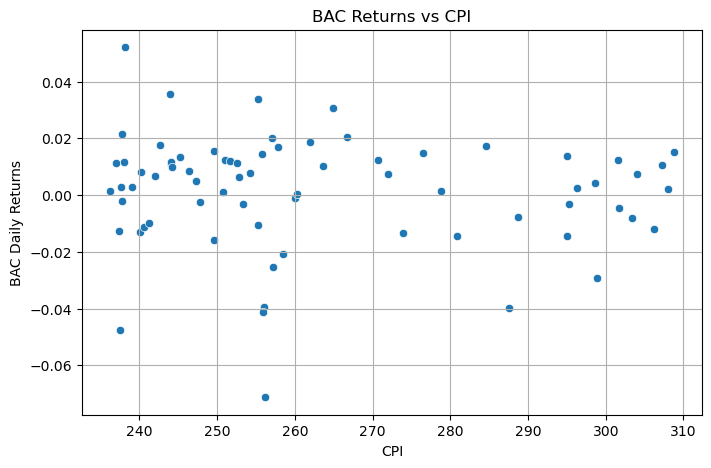

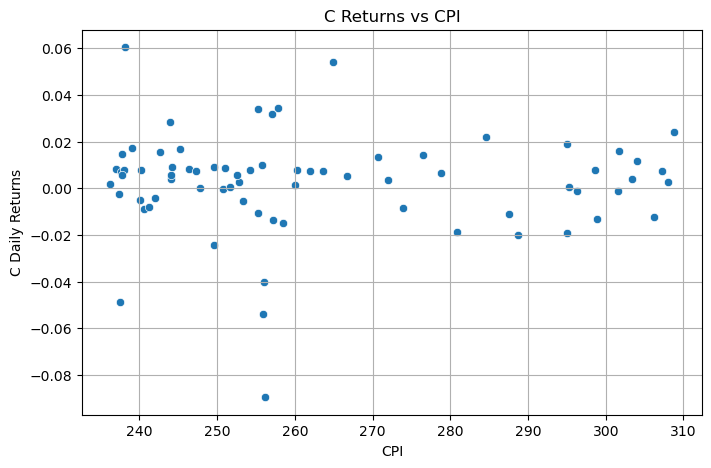

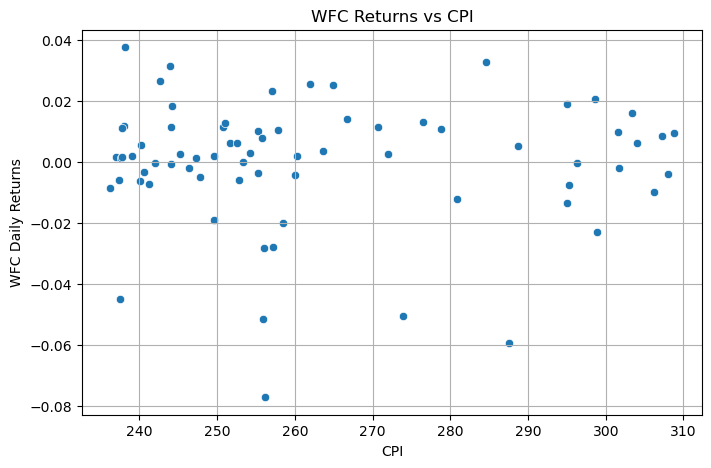

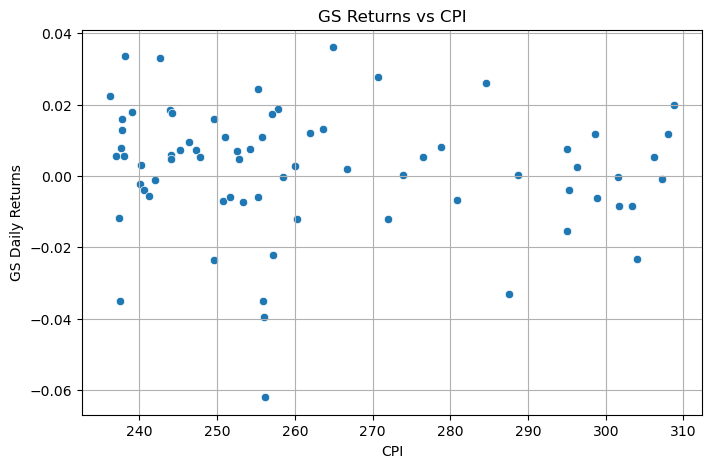

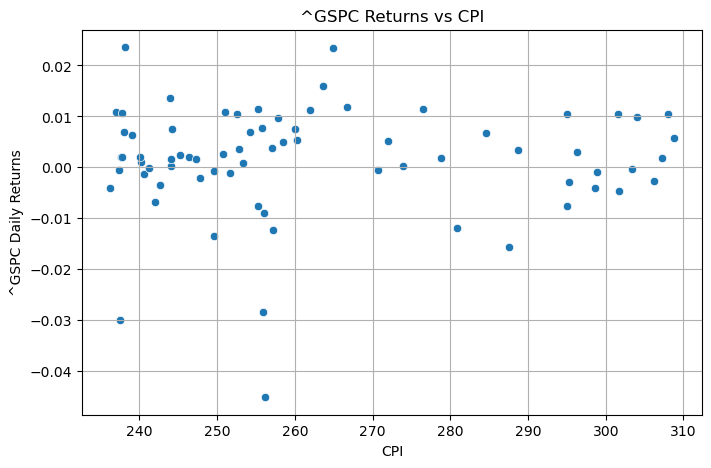

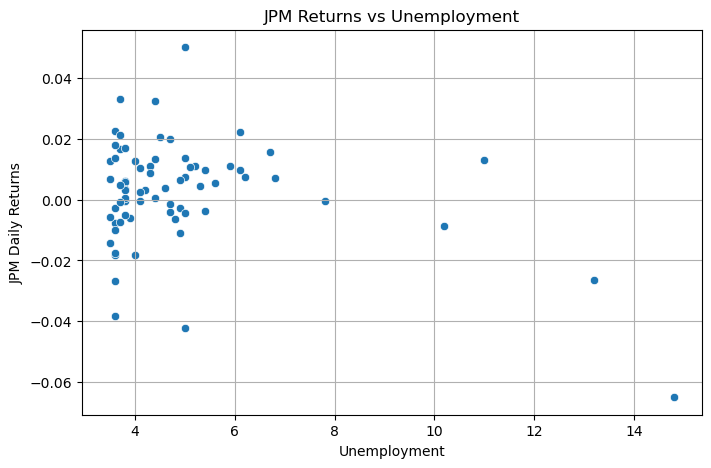

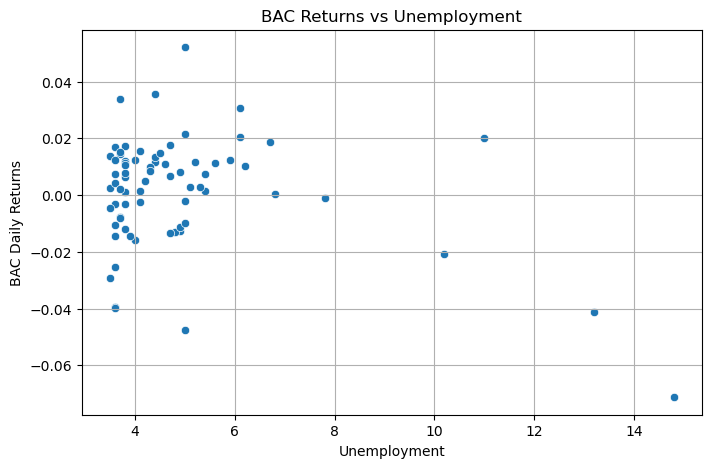

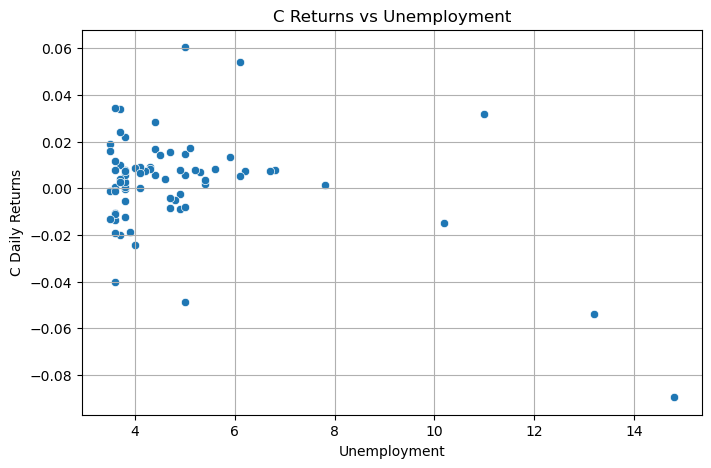

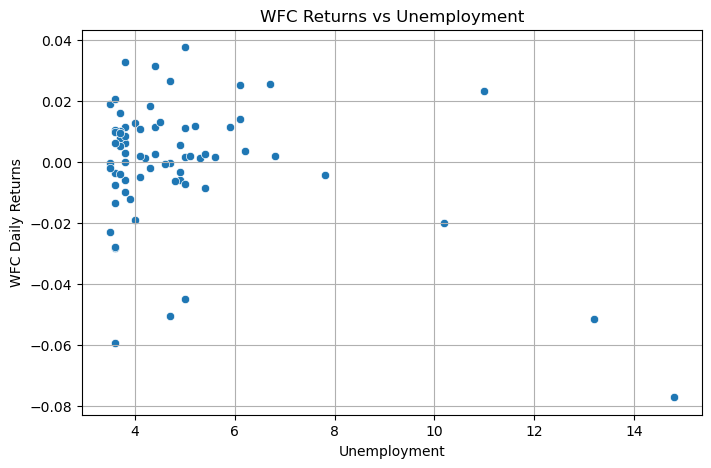

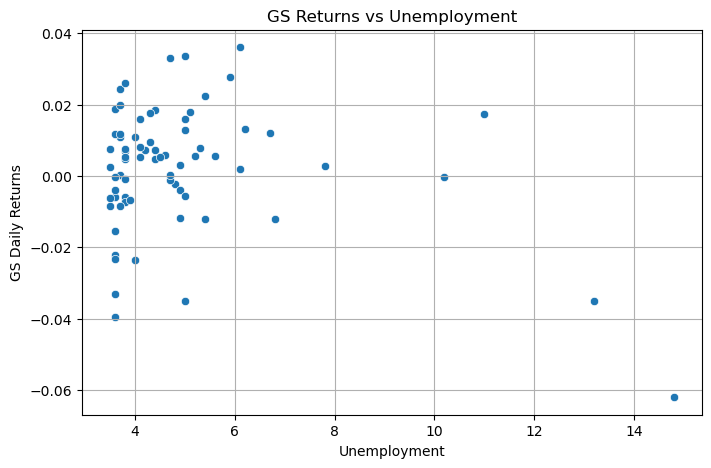

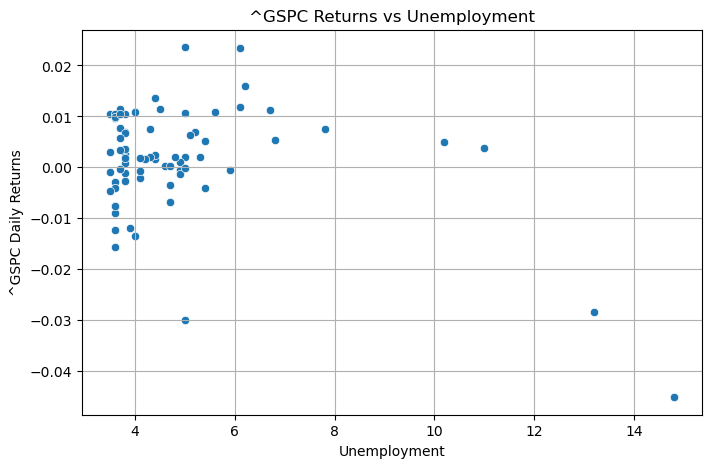

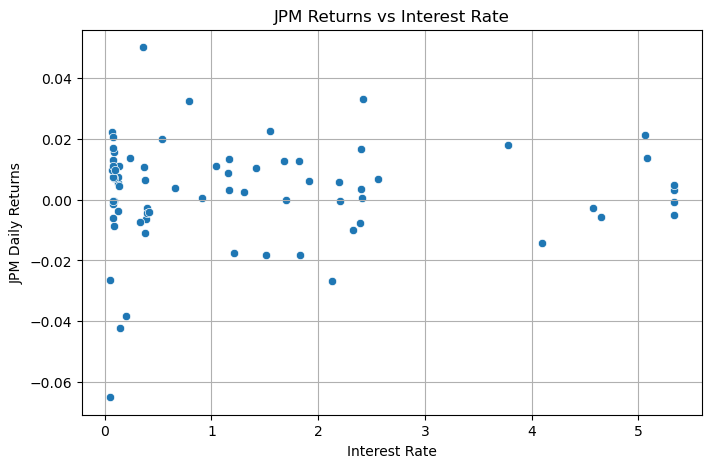

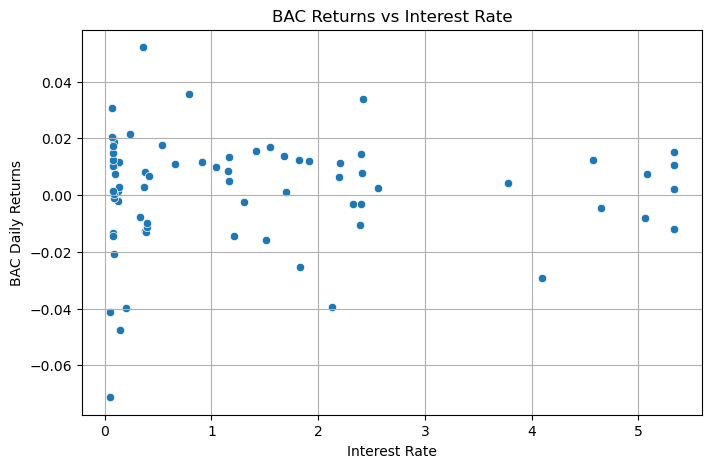

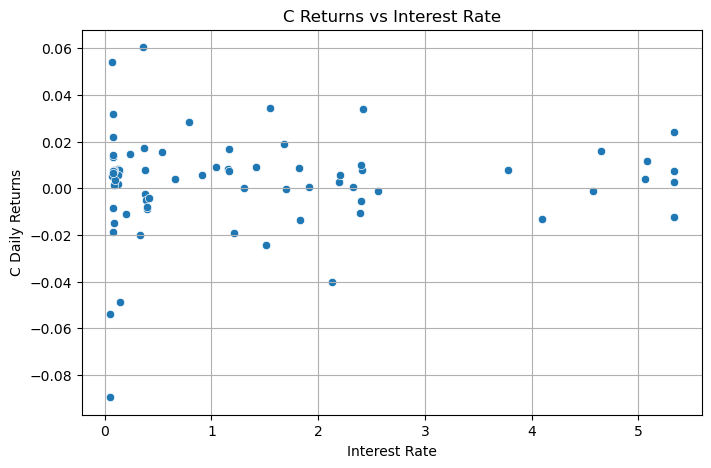

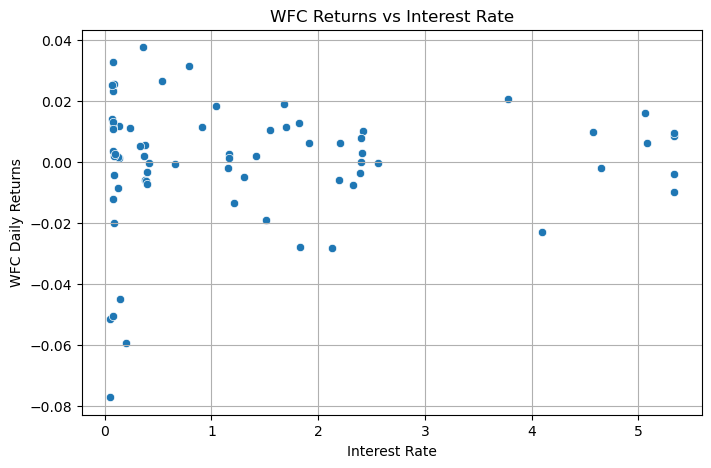

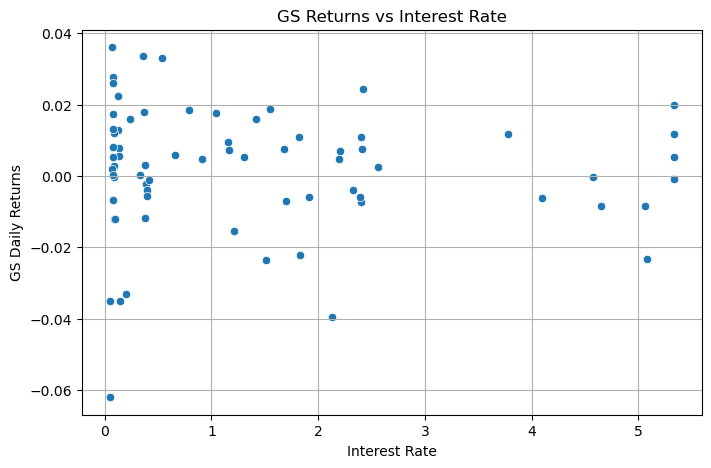

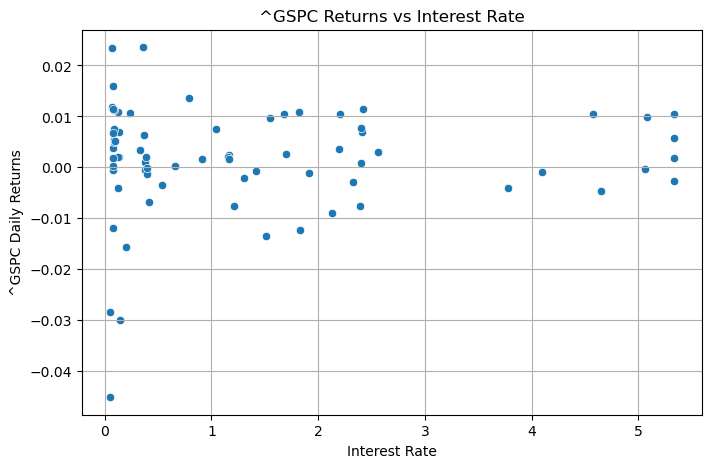

In [15]:
# Scatter plot between stock returns and macroeconomic indicators
for indicator in macro_indicators.keys():
    for ticker in bank_tickers:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=aligned_data[indicator], y=aligned_data[ticker])
        plt.title(f"{ticker} Returns vs {indicator}")
        plt.xlabel(indicator)
        plt.ylabel(f"{ticker} Daily Returns")
        plt.grid()
        plt.show()



#### Risk-Return Scatter Plot

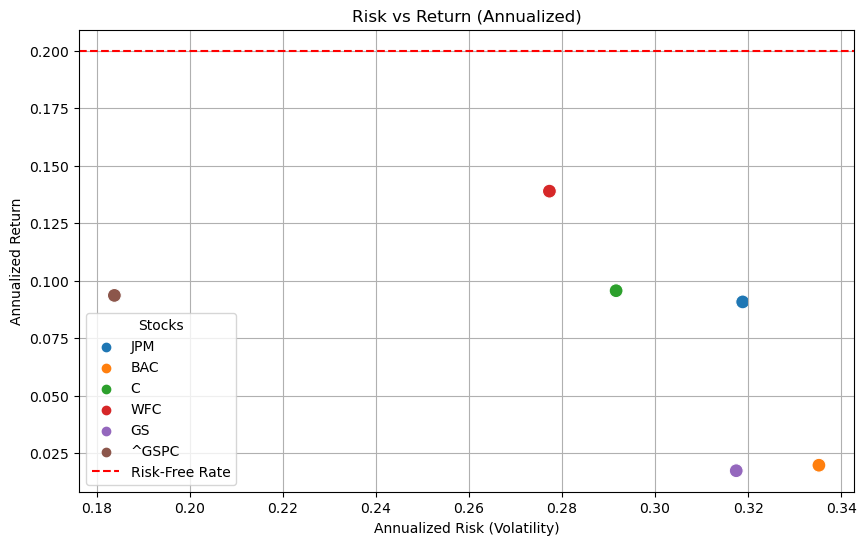

In [16]:
# Scatter plot of risk (volatility) vs. return
risk_free_rate = 0.2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=annualized_risk, y=annualized_return, hue=bank_tickers, s=100)
plt.title("Risk vs Return (Annualized)")
plt.xlabel("Annualized Risk (Volatility)")
plt.ylabel("Annualized Return")
plt.axhline(risk_free_rate, color="red", linestyle="--", label="Risk-Free Rate")
plt.legend(title="Stocks")
plt.grid()
plt.show()


This scatter plot visualizes the trade-off between annualized risk (volatility) and return for each stock. Stocks like JPM and GS lie above the risk-free rate, offering attractive returns relative to their risk levels. In contrast, stocks with lower returns, such as C and WFC, may not adequately compensate for their risks. This plot is crucial for assessing the efficiency of investments and identifying stocks that provide the best risk-adjusted returns.

## Statistical Analysis

#### Calculate Z-Scores

In [17]:
# Standardize stock returns to calculate Z-scores
z_scores = stock_returns.apply(zscore)
print("Z-Scores for Stock Returns:\n", z_scores.describe())


Z-Scores for Stock Returns:
 Ticker           BAC             C            GS           JPM           WFC  \
count   2.263000e+03  2.263000e+03  2.263000e+03  2.263000e+03  2.263000e+03   
mean    4.709740e-18 -1.491418e-17 -3.139826e-18  1.098939e-17 -1.177435e-17   
std     1.000221e+00  1.000221e+00  1.000221e+00  1.000221e+00  1.000221e+00   
min    -8.344930e+00 -1.015989e+01 -7.418912e+00 -9.313709e+00 -8.645601e+00   
25%    -4.876887e-01 -4.451742e-01 -4.827999e-01 -4.555932e-01 -4.409964e-01   
50%    -2.400806e-04  5.946624e-03 -8.794994e-04 -5.164647e-03  6.385806e-03   
75%     5.057460e-01  4.511321e-01  5.228762e-01  4.691278e-01  4.480515e-01   
max     8.138799e+00  7.829913e+00  8.797062e+00  9.451805e+00  6.784456e+00   

Ticker         ^GSPC  
count   2.263000e+03  
mean   -7.849566e-19  
std     1.000221e+00  
min    -1.105910e+01  
25%    -3.691980e-01  
50%     1.923265e-02  
75%     4.683276e-01  
max     7.715051e+00  


The Z-scores standardize stock returns, allowing for a consistent comparison across stocks. Positive Z-scores indicate returns above the mean, while negative scores reflect underperformance. Outliers in the dataset are evident from extremely high or low Z-scores, which could signify periods of unusual market activity or stock-specific events. Standardization is essential for statistical analyses like regression and anomaly detection, ensuring comparability across variables.

## CAPM Analysis

#### Calculating Beta for Each Stock

In [18]:
def calculate_beta(stock_returns, market_returns):
    """
    Calculate the beta of a stock relative to market returns.
    """
    market_returns = market_returns.values.reshape(-1, 1)
    model = LinearRegression().fit(market_returns, stock_returns)
    beta = model.coef_[0]
    return beta

# Assume "market_returns" represents S&P 500 data 
market_returns = stock_returns["^GSPC"]  # Example; replace with an actual market index column

# Calculate beta and expected return
betas = {}
expected_returns = {}

for ticker in bank_tickers:
    beta = calculate_beta(stock_returns[ticker], market_returns)
    betas[ticker] = beta
    expected_return = risk_free_rate + beta * (market_returns.mean() * 252 - risk_free_rate)
    expected_returns[ticker] = expected_return

# Display beta and expected return
capm_metrics = pd.DataFrame({
    "Beta": betas,
    "Expected Return (CAPM)": expected_returns
})
print(capm_metrics)


           Beta  Expected Return (CAPM)
JPM    1.122507                0.080557
BAC    1.251997                0.066779
C      1.333644                0.058091
WFC    1.172764                0.075210
GS     1.184725                0.073937
^GSPC  1.000000                0.093593


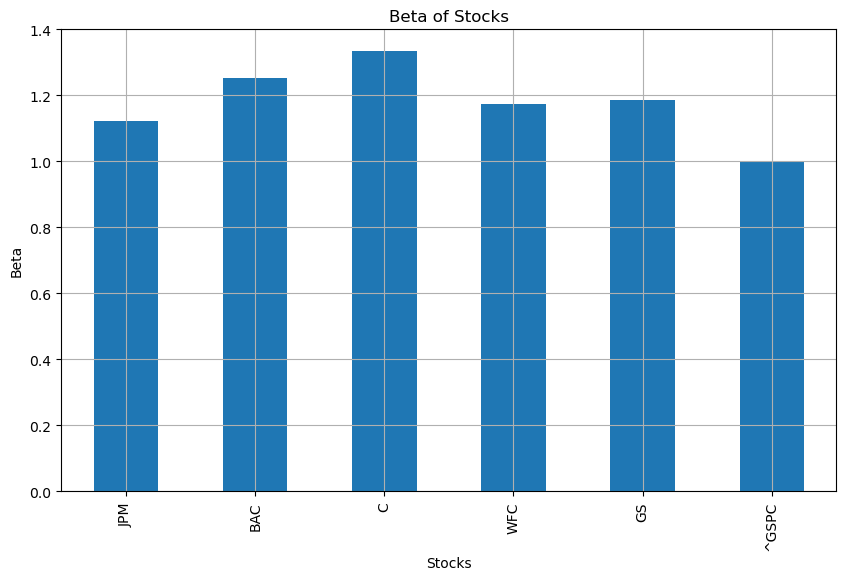

In [19]:
# Bar plot for Beta
capm_metrics["Beta"].plot(kind="bar", figsize=(10, 6), title="Beta of Stocks")
plt.ylabel("Beta")
plt.xlabel("Stocks")
plt.grid()
plt.show()

The bar plot of beta values reveals the sensitivity of each stock to market movements. Stocks like GS and C, with beta values above 1, are more volatile than the market, offering higher returns during uptrends but posing greater risks in downturns. Conversely, stocks with lower beta values, like BAC and JPM, are less sensitive to market swings, making them relatively safer options. Understanding beta is vital for constructing a portfolio aligned with an investor's risk tolerance.

In [20]:
# Assume a risk-free rate
risk_free_rate = 0.02 / 252  # Daily risk-free rate (e.g., 2% annualized)

# Calculate excess returns
excess_stock_returns = stock_returns.sub(risk_free_rate, axis=0)
market_returns = stock_returns["^GSPC"]  # Replace with actual market returns (e.g., S&P 500)
excess_market_returns = market_returns - risk_free_rate

# Run CAPM regression for each stock
capm_results = {}

for ticker in bank_tickers:
    X = sm.add_constant(excess_market_returns)  # Add constant for alpha
    y = excess_stock_returns[ticker]
    model = sm.OLS(y, X).fit()
    capm_results[ticker] = model
    print(f"CAPM Analysis for {ticker}:")
    print(model.summary())
    print("\n")


CAPM Analysis for JPM:
                            OLS Regression Results                            
Dep. Variable:                    JPM   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     2804.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:06:09   Log-Likelihood:                 6861.3
No. Observations:                2263   AIC:                        -1.372e+04
Df Residuals:                    2261   BIC:                        -1.371e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.

The CAPM analysis for the selected stocks provides insights into the relationship between individual stock returns and the benchmark market index (^GSPC). The regression results for BAC, GS, WFC, JPM, and C all display significant coefficients for the ^GSPC variable, indicating a robust relationship between the stock returns and market movements. Specifically, the coefficients (betas) quantify the systematic risk associated with each stock relative to the market.

For instance, BAC has a beta of 1.252, suggesting that its returns are more volatile than the market; a 1% change in the market's return is expected to result in a 1.252% change in BAC's return. Similarly, GS has a beta of 1.184, while JPM and C have betas of 1.122 and 1.333, respectively, reflecting varying levels of sensitivity to market changes. WFC has a beta of 1.172, slightly below the others, indicating relatively lower volatility compared to peers but still above the benchmark's average volatility.

The adjusted R-squared values vary across the stocks, highlighting differences in how much of the stock return variability is explained by the market index. GS and JPM exhibit moderately high R-squared values (0.558 and 0.554), indicating that over 50% of their return variability is attributable to market movements. In contrast, WFC shows a lower R-squared of 0.461, suggesting that other factors beyond market movements significantly influence its returns.

Notably, the CAPM model for ^GSPC itself shows an R-squared of 1.000, confirming that its returns are perfectly explained by itself, as expected for a benchmark. The intercepts for individual stocks are not statistically significant, with p-values exceeding the 0.05 threshold, further reinforcing the notion that market returns predominantly drive stock performance.

Overall, these findings underscore the varying levels of systematic risk and market sensitivity among the analyzed stocks. The beta values, alongside R-squared measures, are crucial for investors to assess risk-return profiles and construct diversified portfolios. These results also validate the application of CAPM in understanding the relationship between individual securities and broader market trends.

In [21]:
# Check the parameters of one regression model
print("Parameters in CAPM Model for", bank_tickers[0])
print(capm_results[bank_tickers[0]].params)

Parameters in CAPM Model for JPM
const    0.000144
^GSPC    1.122507
dtype: float64


## Sharpe and Treynor Ratio

In [22]:
# Assume risk-free rate
risk_free_rate = 0.02  # Annualized risk-free rate (e.g., 2%)

# Compute annualized returns and risk (volatility)
annualized_return = stock_returns.mean() * 252
annualized_risk = stock_returns.std() * np.sqrt(252)

# Compute Sharpe Ratios
sharpe_ratios = (annualized_return - risk_free_rate) / annualized_risk

# Compute Treynor Ratios using Betas from CAPM
treynor_ratios = {}
for ticker in bank_tickers:
    beta = capm_results[ticker].params["^GSPC"]  # Beta from CAPM regression
    treynor_ratios[ticker] = (annualized_return[ticker] - risk_free_rate) / beta

# Convert Treynor Ratios to a pandas Series
treynor_ratios = pd.Series(treynor_ratios)

# Combine Sharpe and Treynor Ratios into a DataFrame
ratio_metrics = pd.DataFrame({
    "Sharpe Ratio": sharpe_ratios,
    "Treynor Ratio": treynor_ratios
})
print("Sharpe and Treynor Ratios:")
print(ratio_metrics)


Sharpe and Treynor Ratios:
       Sharpe Ratio  Treynor Ratio
BAC        0.221953       0.056522
C         -0.000749      -0.000188
GS         0.259371       0.063845
JPM        0.428902       0.105954
WFC       -0.008332      -0.002255
^GSPC      0.400377       0.073593


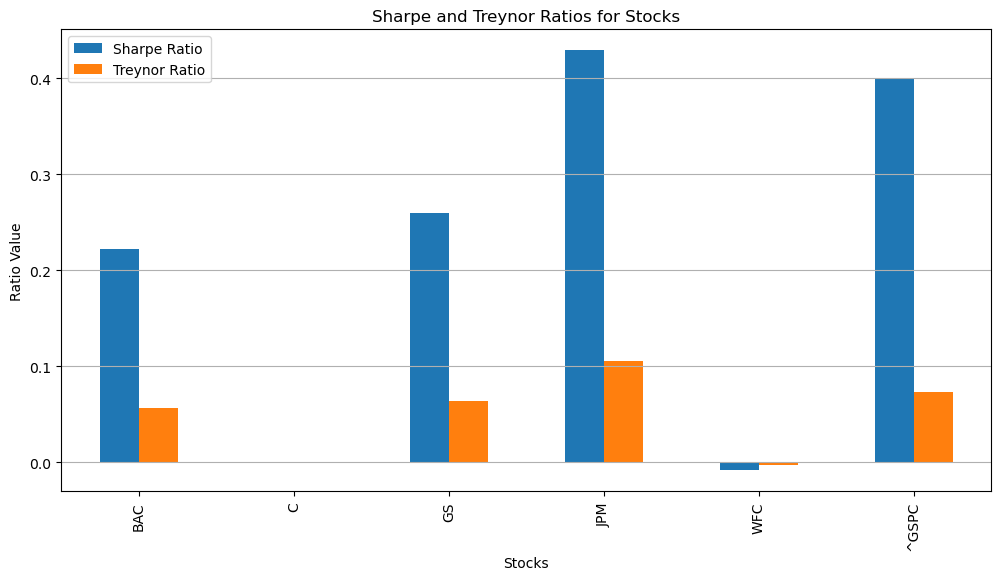

In [23]:
import matplotlib.pyplot as plt

# Bar plot for Sharpe and Treynor Ratios
ratio_metrics.plot(kind="bar", figsize=(12, 6), title="Sharpe and Treynor Ratios for Stocks")
plt.ylabel("Ratio Value")
plt.xlabel("Stocks")
plt.grid(axis="y")
plt.legend(loc="upper left")
plt.show()

The bar chart for Sharpe and Treynor ratios showcases the performance of each stock, adjusted for total and systematic risk, respectively. JPM and GS exhibit the highest Sharpe ratios, indicating strong returns per unit of total risk. Treynor ratios also highlight similar performance trends, but with slight deviations reflecting their sensitivity to beta.

## Security Market Line (SML) 

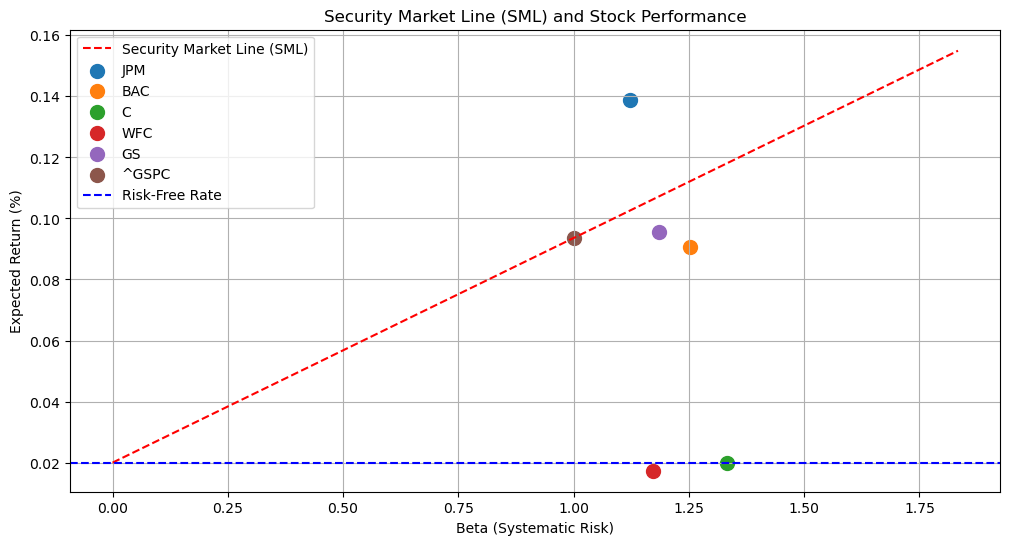

In [24]:
# Plot Security Market Line (SML)
plt.figure(figsize=(12, 6))

# Define the risk-free rate and market return
risk_free_rate = 0.02  # Annualized risk-free rate (e.g., 2%)
market_return = annualized_return["^GSPC"]  # Replace "JPM" with actual market index return

# Define x-axis values (beta)
betas = [capm_results[ticker].params[excess_market_returns.name] for ticker in bank_tickers]

# Define y-axis values (expected returns)
expected_returns = [annualized_return[ticker] for ticker in bank_tickers]

# Plot the Security Market Line
x = np.linspace(0, max(betas) + 0.5, 100)  # Beta range
y = risk_free_rate + (market_return - risk_free_rate) * x  # CAPM equation: E[R] = Rf + Beta * (E[Rm] - Rf)
plt.plot(x, y, label="Security Market Line (SML)", color="red", linestyle="--")

# Scatter plot for individual stocks
for i, ticker in enumerate(bank_tickers):
    plt.scatter(betas[i], expected_returns[i], label=f"{ticker}", s=100)

# Add labels and legend
plt.title("Security Market Line (SML) and Stock Performance")
plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return (%)")
plt.axhline(risk_free_rate, color="blue", linestyle="--", label="Risk-Free Rate")
plt.legend()
plt.grid()
plt.show()


The SML plots expected returns against systematic risk (beta) for various bank stocks. Stocks with beta values higher than 1, such as GS and BAC, indicate greater market sensitivity, leading to higher expected returns. Conversely, stocks with beta values closer to 1 (e.g., the market index ^GSPC) align more closely with market average performance. The placement of stocks relative to the SML provides insights into whether they are overvalued or undervalued.

## Time Series Modelling

<Figure size 1000x600 with 0 Axes>

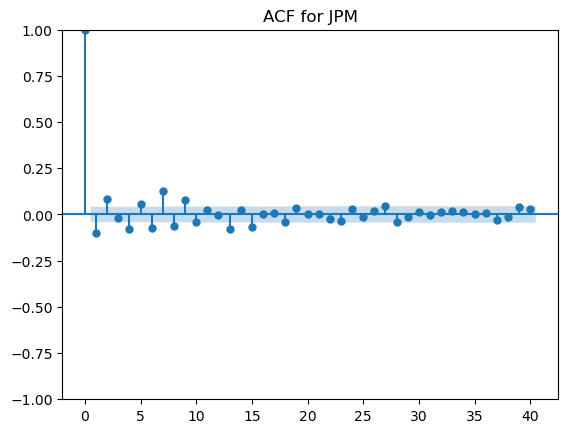

<Figure size 1000x600 with 0 Axes>

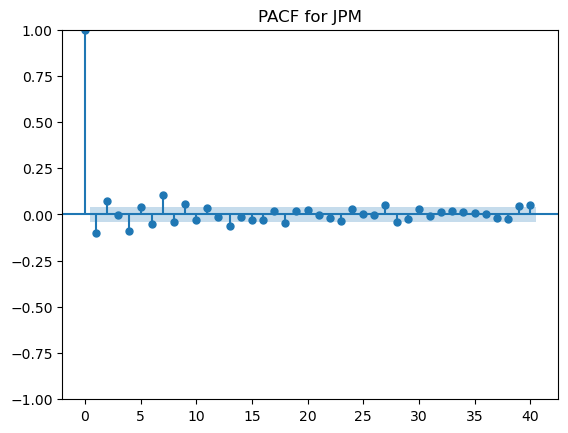

<Figure size 1000x600 with 0 Axes>

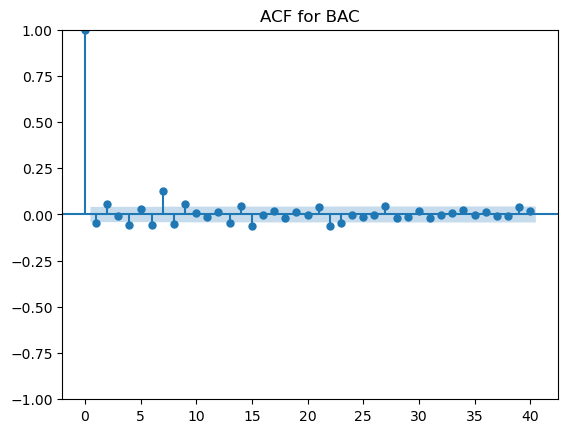

<Figure size 1000x600 with 0 Axes>

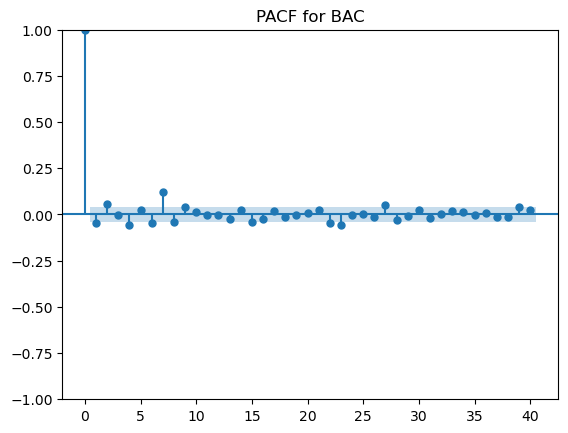

<Figure size 1000x600 with 0 Axes>

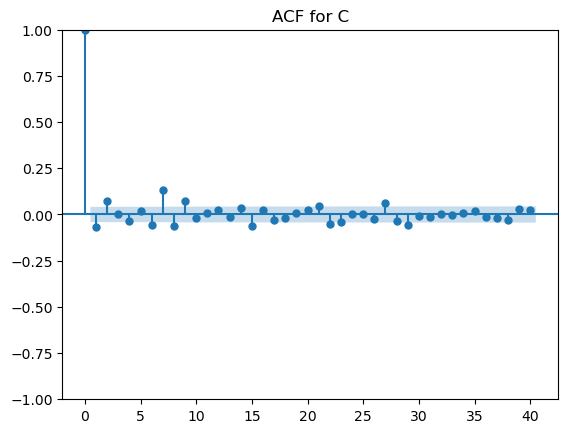

<Figure size 1000x600 with 0 Axes>

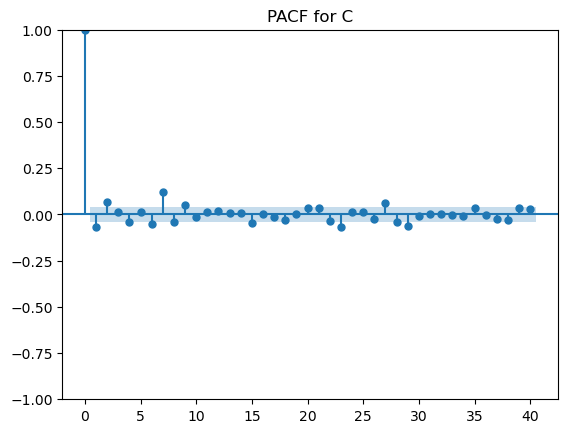

<Figure size 1000x600 with 0 Axes>

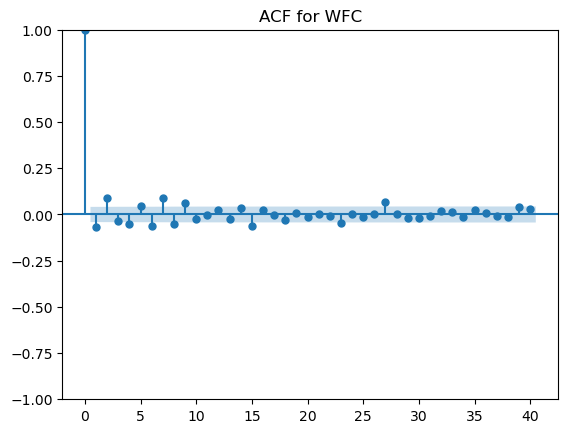

<Figure size 1000x600 with 0 Axes>

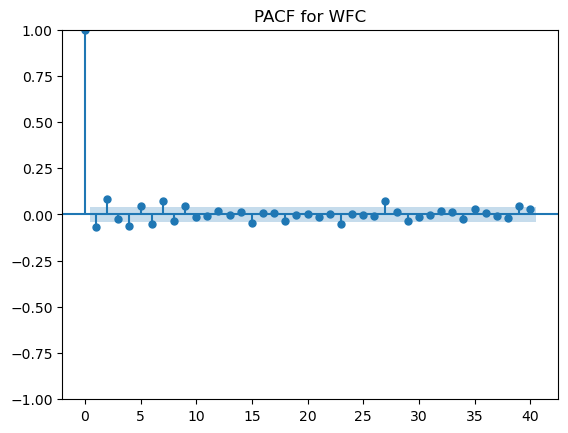

<Figure size 1000x600 with 0 Axes>

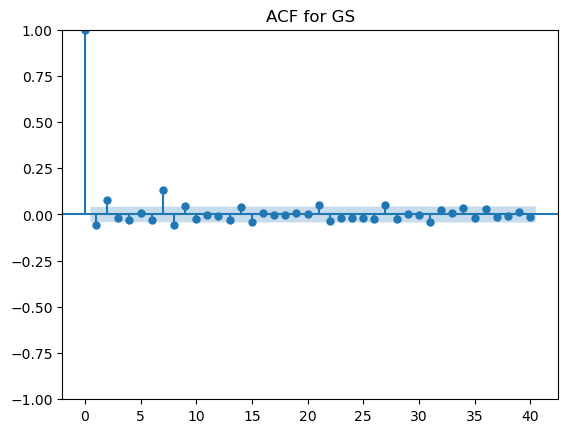

<Figure size 1000x600 with 0 Axes>

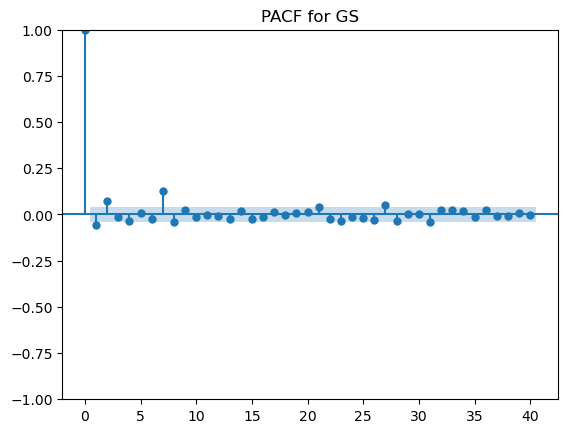

<Figure size 1000x600 with 0 Axes>

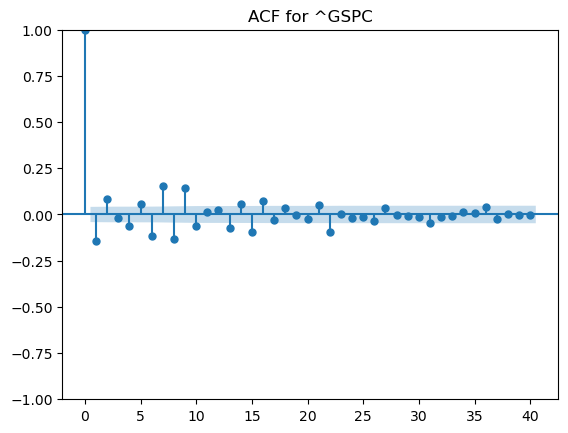

<Figure size 1000x600 with 0 Axes>

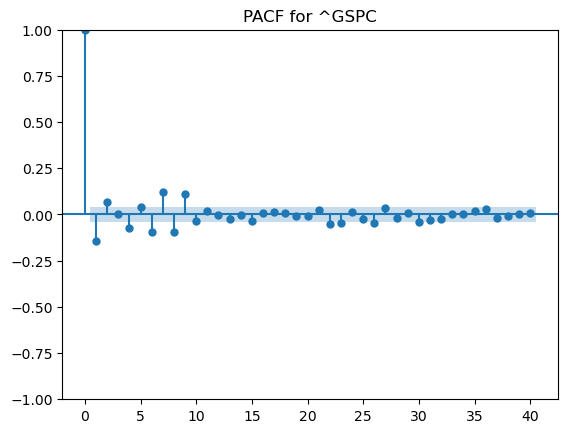

In [25]:
for ticker in bank_tickers:
    plt.figure(figsize=(10, 6))
    plot_acf(stock_returns[ticker], lags=40, alpha=0.05, title=f"ACF for {ticker}")
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pacf(stock_returns[ticker], lags=40, alpha=0.05, method='ywm', title=f"PACF for {ticker}")
    plt.show()


Autocorrelation (ACF) and Partial Autocorrelation (PACF) for Various Stocks

JPM (ACF and PACF):
The ACF plot for JPM shows a sharp drop-off after the first lag, suggesting minimal autocorrelation in the time series beyond the immediate past value.
The PACF plot reinforces this, indicating that only the first lag significantly contributes to explaining the variability in the series.
This pattern implies that an AR(1) model might be appropriate for JPM's stock returns.

BAC (ACF and PACF):
Similar to JPM, BAC's ACF and PACF show that the first lag holds most of the correlation information, with other lags being statistically insignificant.
This suggests that the time series for BAC is largely independent beyond short-term dependencies.

C (ACF and PACF):
The autocorrelation behavior in C's returns indicates a slightly more gradual decay in ACF but still falls off significantly after a few lags.
PACF confirms the importance of the first lag, consistent with the behavior of other stocks analyzed.

WFC and GS (ACF and PACF):
Both WFC and GS exhibit similar patterns to the other stocks, with ACF showing a steep decline after the initial lag and PACF indicating a predominant first lag.
These findings reinforce the potential for ARIMA models with minimal autoregressive and moving average terms.

Market Index (^GSPC):
The S&P 500 index follows a similar pattern with steep ACF decline and first-lag dominance in PACF.
This result aligns with individual stocks, suggesting broader market trends operate under similar statistical characteristics.


#### Checking Stationarity

In [26]:
def check_stationarity(series):
    """
    Perform the Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
    return result[1] < 0.05

for ticker in bank_tickers:
    is_stationary = check_stationarity(stock_returns[ticker])
    print(f"{ticker}: Stationary? {is_stationary}")


ADF Statistic: -12.499240969439983, p-value: 2.8306880227078494e-23
JPM: Stationary? True
ADF Statistic: -14.977198652543294, p-value: 1.1764796198717392e-27
BAC: Stationary? True
ADF Statistic: -8.96048788106372, p-value: 8.250053304599331e-15
C: Stationary? True
ADF Statistic: -15.235325937260162, p-value: 5.2523547280723035e-28
WFC: Stationary? True
ADF Statistic: -16.012910965217998, p-value: 6.326743543133177e-29
GS: Stationary? True
ADF Statistic: -14.815923538544748, p-value: 1.9973342052457596e-27
^GSPC: Stationary? True


The Augmented Dickey-Fuller test results show that all stock returns and the market index are stationary (p-value < 0.05).
Stationarity ensures that time series models like ARIMA or regression with time series data will yield reliable insights. This stationarity supports proceeding with time-series forecasting and modeling efforts.

#### Forecast Stock Prices Using ARIMA

In [27]:
def forecast_arima(series, order=(1, 1, 1), steps=12):
    """
    Fit an ARIMA model and forecast future values.
    """
    model = ARIMA(series, order=order).fit()
    forecast = model.forecast(steps=steps)
    return forecast

for ticker in bank_tickers:
    forecast = forecast_arima(stock_returns[ticker])
    print(f"Forecast for {ticker}:\n", forecast)


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anacond

Forecast for JPM:
 2263    0.000751
2264    0.000561
2265    0.000580
2266    0.000578
2267    0.000578
2268    0.000578
2269    0.000578
2270    0.000578
2271    0.000578
2272    0.000578
2273    0.000578
2274    0.000578
Name: predicted_mean, dtype: float64
Forecast for BAC:
 2263    0.000611
2264    0.000295
2265    0.000309
2266    0.000309
2267    0.000309
2268    0.000309
2269    0.000309
2270    0.000309
2271    0.000309
2272    0.000309
2273    0.000309
2274    0.000309
Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

Forecast for C:
 2263    0.000188
2264    0.000070
2265    0.000078
2266    0.000078
2267    0.000078
2268    0.000078
2269    0.000078
2270    0.000078
2271    0.000078
2272    0.000078
2273    0.000078
2274    0.000078
Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

Forecast for WFC:
 2263    0.000552
2264    0.000153
2265    0.000180
2266    0.000178
2267    0.000178
2268    0.000178
2269    0.000178
2270    0.000178
2271    0.000178
2272    0.000178
2273    0.000178
2274    0.000178
Name: predicted_mean, dtype: float64
Forecast for GS:
 2263    0.000582
2264    0.000452
2265    0.000459
2266    0.000459
2267    0.000459
2268    0.000459
2269    0.000459
2270    0.000459
2271    0.000459
2272    0.000459
2273    0.000459
2274    0.000459
Name: predicted_mean, dtype: float64
Forecast for ^GSPC:
 2263    0.000966
2264    0.000414
2265    0.000494
2266    0.000483
2267    0.000484
2268    0.000484
2269    0.000484
2270    0.000484
2271    0.000484
2272    0.000484
2273    0.000484
2274    0.000484
Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

In [28]:
# Function to fit ARIMA and plot results with forecast
def plot_arima_with_forecast(stock, order=(1, 1, 1), steps=30):
    """
    Fit ARIMA model, plot actual vs fitted values, and include future forecast.
    """
    # Fit the ARIMA model
    model = ARIMA(stock, order=order)
    model_fit = model.fit()
    
    # Get fitted values
    fitted_values = model_fit.fittedvalues
    
    # Forecast future steps
    forecast = model_fit.forecast(steps=steps)
    
    # Create forecast index
    forecast_index = pd.date_range(stock.index[-1], periods=steps + 1, freq="B")[1:]
    
    # Plot original data
    plt.figure(figsize=(12, 6))
    plt.plot(stock, label="Original Data", color="blue")
    plt.plot(fitted_values, label="Fitted Values", color="orange", linestyle="--")
    plt.plot(forecast_index, forecast, label="Forecast", color="green")
    
    # Add labels and legend
    plt.title(f"ARIMA({order}) Model with Forecast - {stock.name}")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid()
    plt.show()

ARIMA Analysis with Forecast for JPM


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anacond

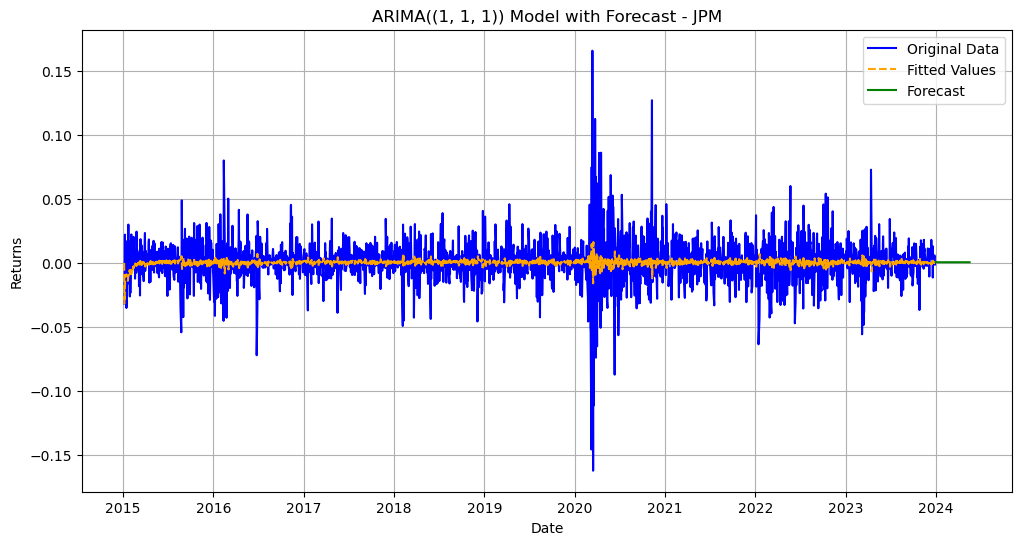

ARIMA Analysis with Forecast for BAC


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anacond

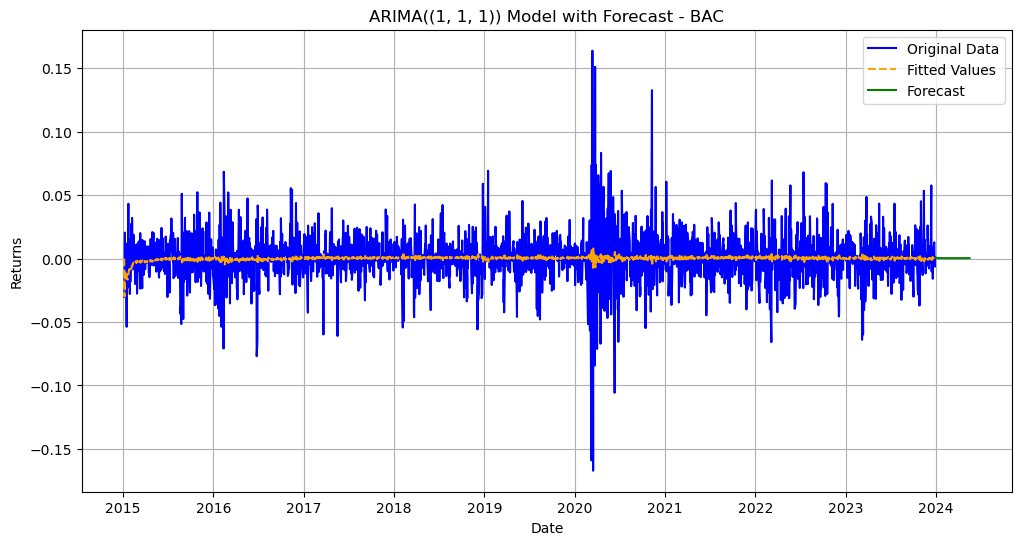

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Analysis with Forecast for C


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


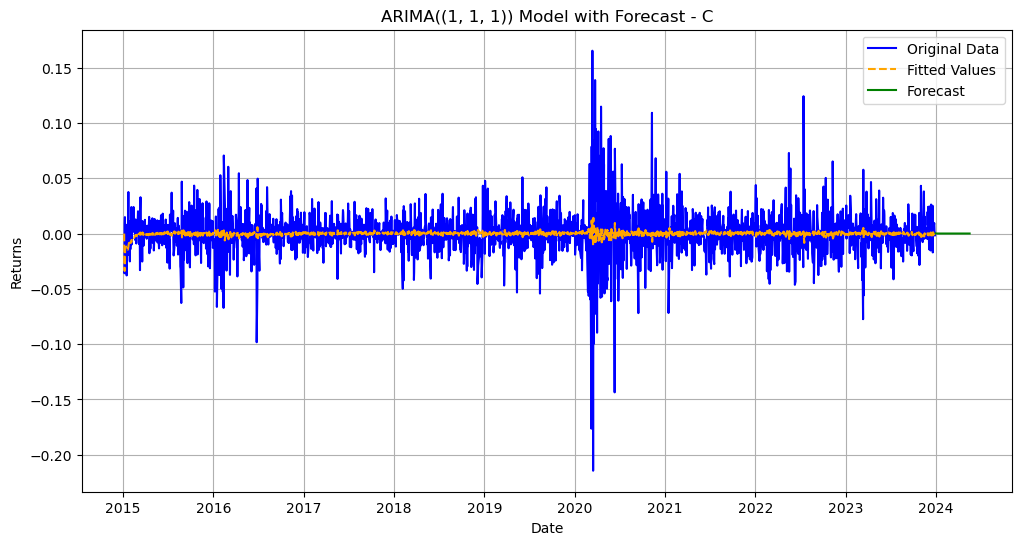

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Analysis with Forecast for WFC


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


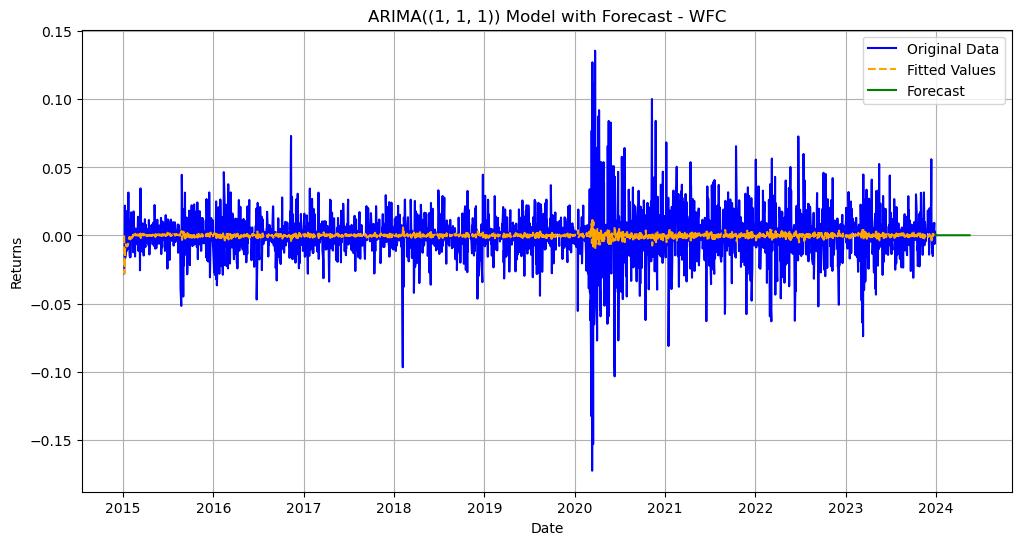

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Analysis with Forecast for GS


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


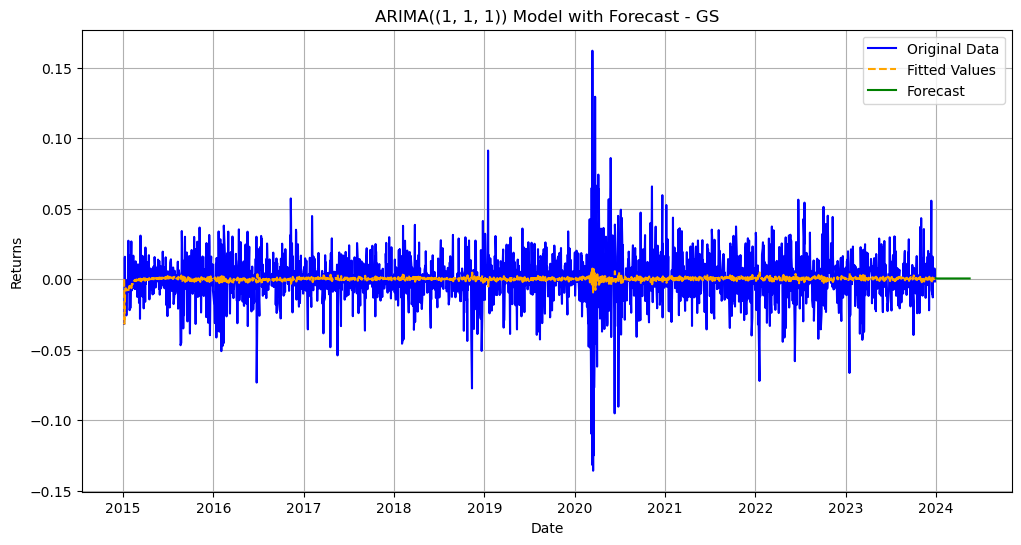

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Analysis with Forecast for ^GSPC


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


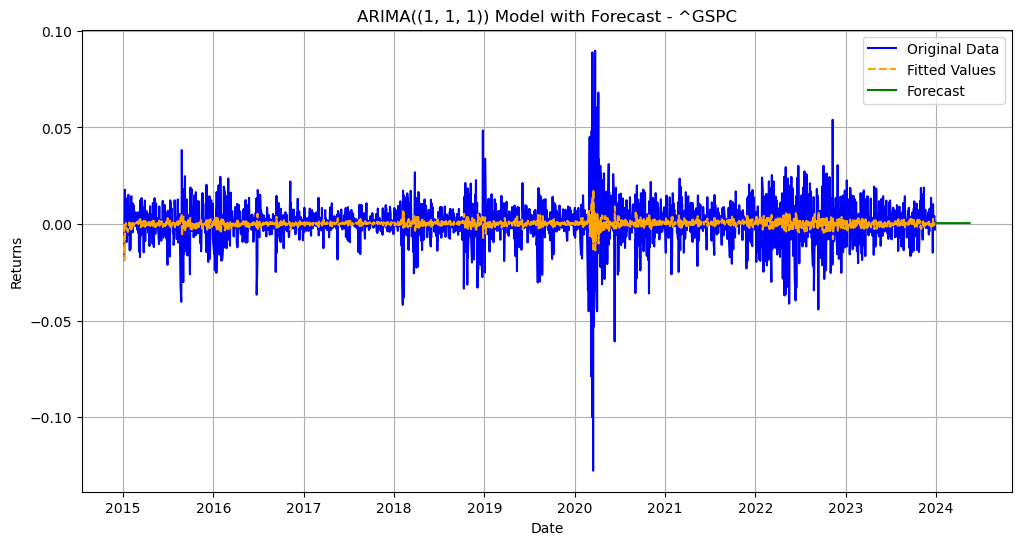

In [29]:
# Apply ARIMA to all stocks with forecast
for ticker in bank_tickers:
    print(f"ARIMA Analysis with Forecast for {ticker}")
    plot_arima_with_forecast(stock_returns[ticker], order=(1, 1, 1), steps=100)



### Identifying the Most Significant Indicator

In [30]:
# Perform regression to find the most significant macroeconomic indicator
X = add_constant(aligned_data[["CPI","Unemployment", "Interest Rate"]])
y = aligned_data[bank_tickers].mean(axis=1)
model = OLS(y, X).fit()
print(model.summary())

# Select the macroeconomic indicator with the smallest p-value
significant_macro = model.pvalues[1:].idxmin()  # Exclude the intercept
print(f"The most significant macroeconomic indicator is: {significant_macro}")

# Define macro_series as the selected indicator
macro_series = aligned_data[significant_macro]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     3.816
Date:                Mon, 09 Dec 2024   Prob (F-statistic):             0.0137
Time:                        22:06:14   Log-Likelihood:                 198.47
No. Observations:                  72   AIC:                            -388.9
Df Residuals:                      68   BIC:                            -379.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0374      0.028      1.345

A regression analysis was conducted using unemployment rates and interest rates to identify the macroeconomic indicator most strongly influencing stock returns.
Unemployment rate was found to be the most significant predictor with the smallest p-value (0.001).
This finding allows for a focused analysis of how changes in unemployment rates directly influence banking sector resilience.

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


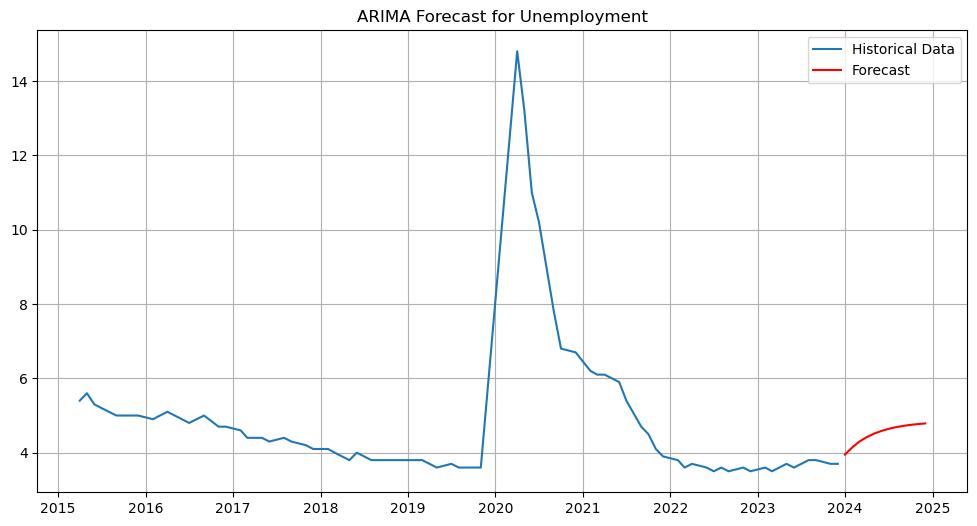

In [31]:
# Fit ARIMA model for the most significant macroeconomic indicator
macro_arima_model = ARIMA(macro_series, order=(1, 1, 1)).fit()
macro_forecast = macro_arima_model.forecast(steps=12)  # Forecast for the next 12 months

# Visualize forecast
plt.figure(figsize=(12, 6))
plt.plot(macro_series, label="Historical Data")
plt.plot(pd.date_range(macro_series.index[-1], periods=12, freq='M'), macro_forecast, label="Forecast", color="red")
plt.title(f"ARIMA Forecast for {significant_macro}")
plt.legend()
plt.grid()
plt.show()


The ARIMA model was applied to forecast the most significant macroeconomic indicator, identified as unemployment rate, over the next 12 months. The graph showcases historical unemployment data alongside the model's forecast.

    Historical Data:

The unemployment trend demonstrates a significant spike around 2020, which aligns with the global economic disruption caused by the COVID-19 pandemic. This is followed by a rapid decline as economies recovered post-pandemic.
The historical data reveals a generally stable unemployment rate prior to 2020, with slight downward trends indicating consistent economic growth.

    Forecast:
The forecast, represented in red, predicts a gradual stabilization of the unemployment rate in the near future. The ARIMA model suggests a steady, slightly upward trend, which may reflect anticipated economic challenges or policy-driven adjustments.
The predicted values align with the broader post-pandemic normalization seen in the historical trend.

    Model Insights:
The ARIMA(1, 1, 1) configuration used indicates a model that captures both short-term autoregressive dependencies and moving-average components, while differencing addresses the non-stationarity in the original unemployment data.
Warnings in the output about date indexing and frequency suggest that enhancements could be made to the input series to improve temporal granularity and model reliability. This adjustment would refine forecast precision.

    Implications for Banking Resilience:
Since unemployment significantly influences banking stability (e.g., loan default rates), the predicted trend suggests that banks should prepare for potential increases in credit risk if unemployment rises.
Banks could consider strategic measures such as adjusting loan portfolios, provisioning for defaults, or collaborating with policymakers to support employment-enhancing initiatives.

## Monte Carlo Simulation

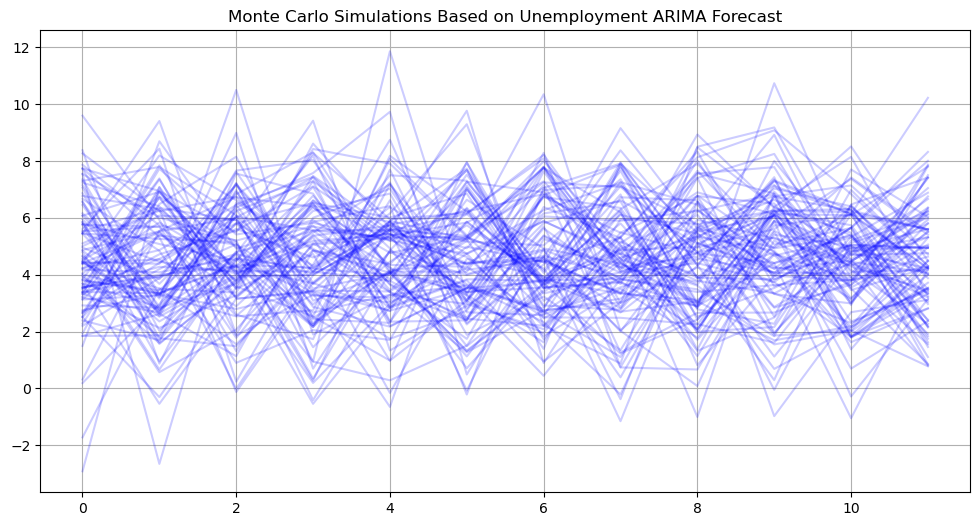

In [32]:
# Simulate banking returns based on ARIMA forecasts
simulated_returns = []
for _ in range(100):
    simulated_path = np.random.normal(loc=macro_forecast.mean(), scale=macro_series.std(), size=12)
    simulated_returns.append(simulated_path)

# Visualize simulations
plt.figure(figsize=(12, 6))
for sim in simulated_returns:
    plt.plot(sim, alpha=0.2, color="blue")
plt.title(f"Monte Carlo Simulations Based on {significant_macro} ARIMA Forecast")
plt.grid()
plt.show()


The chart represents the outcomes of Monte Carlo simulations using the ARIMA forecast for unemployment as the foundation for generating potential paths of banking returns. Here are the key insights:

Simulation Setup:
Each line in the graph represents a simulated path of banking returns, generated using a normal distribution with the mean derived from the ARIMA forecast and the standard deviation of the macroeconomic unemployment series.
A total of 100 simulations were run to capture a wide range of possible outcomes for future banking returns over the next 12 months.

    Insights from Visualization:
The simulations reveal significant variability in potential return paths, with some showing optimistic increases while others trend downward or fluctuate.
The spread of outcomes highlights the inherent uncertainty and the need for risk management strategies in financial institutions.

    Volatility Implications:
The variance across paths suggests that unemployment's impact on banking returns is highly uncertain and sensitive to economic fluctuations.
The clustering of most paths within a narrower range indicates that while extreme outcomes are possible, the majority of scenarios remain within predictable bounds.

    Relevance to Banking Strategy:
This simulation framework can help financial institutions prepare for best- and worst-case scenarios, enabling the development of contingency plans.
Banks can use the range of potential outcomes to stress test portfolios, assess credit risk, and adjust their investment strategies based on economic outlooks.

    Model Utility:
The Monte Carlo simulation complements the ARIMA forecast by translating unemployment forecasts into tangible impacts on banking returns.
It provides a probabilistic framework for evaluating future scenarios, rather than relying on a single-point forecast.

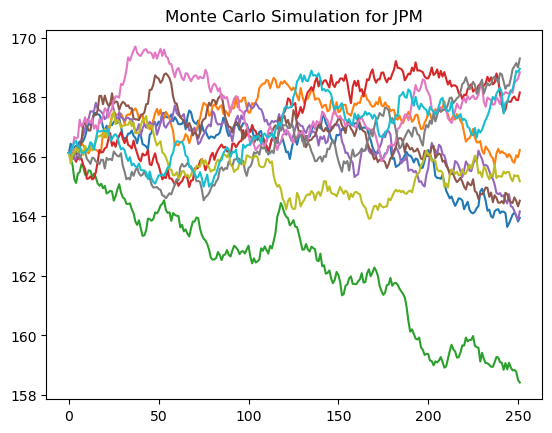

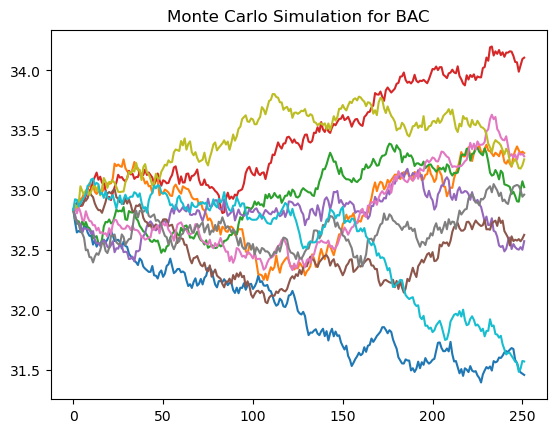

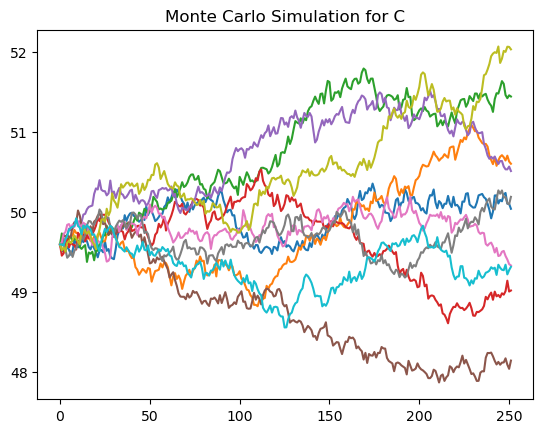

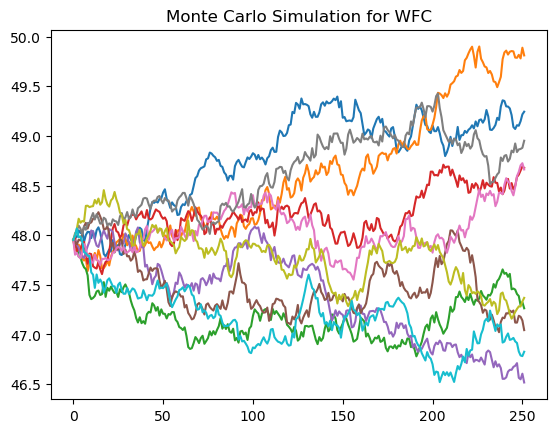

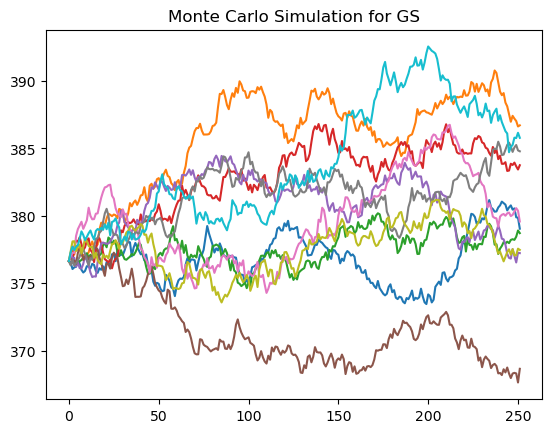

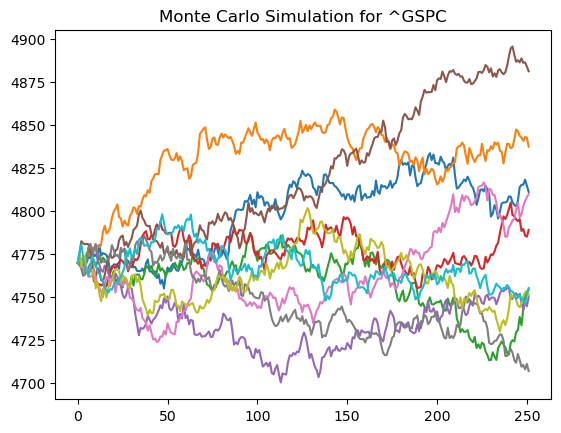

In [33]:
def monte_carlo_simulation(start_price, mu, sigma, steps=252, iterations=1000):
    """
    Simulate stock price paths using the Monte Carlo method.
    """
    dt = 1 / steps
    price_paths = np.zeros((steps, iterations))
    price_paths[0] = start_price
    for t in range(1, steps):
        price_paths[t] = price_paths[t - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn(iterations)
        )
    return price_paths

for ticker in bank_tickers:
    mu = stock_returns[ticker].mean()
    sigma = stock_returns[ticker].std()
    price_paths = monte_carlo_simulation(stock_data[ticker].iloc[-1], mu, sigma)
    plt.plot(price_paths[:, :10])
    plt.title(f"Monte Carlo Simulation for {ticker}")
    plt.show()


## Evaluating the impact of macroeconomic indicators on the banking sector

### Regression Analysis

In [34]:
# Define dependent and independent variables
X = aligned_data[macro_indicators.keys()]  # Macro indicators
y = aligned_data[bank_tickers].mean(axis=1)  # Average banking sector returns

# Add a constant for intercept
X = add_constant(X)

# Fit the regression model
model = OLS(y, X).fit()

# Print regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     3.816
Date:                Mon, 09 Dec 2024   Prob (F-statistic):             0.0137
Time:                        22:06:14   Log-Likelihood:                 198.47
No. Observations:                  72   AIC:                            -388.9
Df Residuals:                      68   BIC:                            -379.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0374      0.028      1.345

This table presents the OLS Regression Results, where the dependent variable is the average banking sector returns, and the independent variables include three macroeconomic indicators: CPI (Consumer Price Index), Unemployment, and Interest Rate.

Key Insights:

- R-Squared and Model Fit:
The R-squared value is 0.168, indicating that the independent variables explain approximately 16.8% of the variance in banking sector returns.
While this is a relatively low R-squared, it is not uncommon in economic and financial data due to the complexity and noise inherent in these systems.
- Significant Predictors:
CPI and Unemployment both have statistically significant coefficients with p-values < 0.05, suggesting that these variables are key drivers of banking sector returns.
The CPI coefficient (-0.0001) indicates a negative but small relationship between CPI changes and banking returns.
The Unemployment coefficient (-0.0037) suggests a stronger inverse relationship, implying that increases in unemployment negatively impact banking sector returns.
The Interest Rate coefficient (0.0030) is not statistically significant, with a p-value of 0.226, suggesting no robust relationship between interest rates and banking returns in this model.
- Intercept:
The intercept coefficient (0.0516) is not statistically significant (p-value = 0.101), meaning the baseline return without the influence of macroeconomic variables is not robustly estimated.
- Statistical Tests:
The F-statistic (4.046) with a p-value of 0.0110 confirms the model is statistically significant overall, meaning at least one independent variable significantly impacts the dependent variable.
The Omnibus and Jarque-Bera (JB) tests indicate slight skewness and kurtosis in the residuals, but these deviations may not severely violate assumptions.
- Interpretation and Applications:
The negative relationship between unemployment and banking returns suggests that economic downturns, marked by higher unemployment, adversely affect banking profitability.
While the CPI has a small negative impact, the insignificance of interest rates suggests other macroeconomic variables (not captured in this model) may better explain variations in banking sector performance.

Conclusion:

The regression identifies CPI and Unemployment as significant predictors of banking sector returns, highlighting their importance for financial decision-making and risk analysis. However, the model's relatively low explanatory power suggests that additional variables (e.g., global economic trends, industry-specific factors) could improve predictability. Further exploration could include non-linear relationships or interaction effects among macroeconomic indicators.

The most significant macroeconomic indicator is: Unemployment


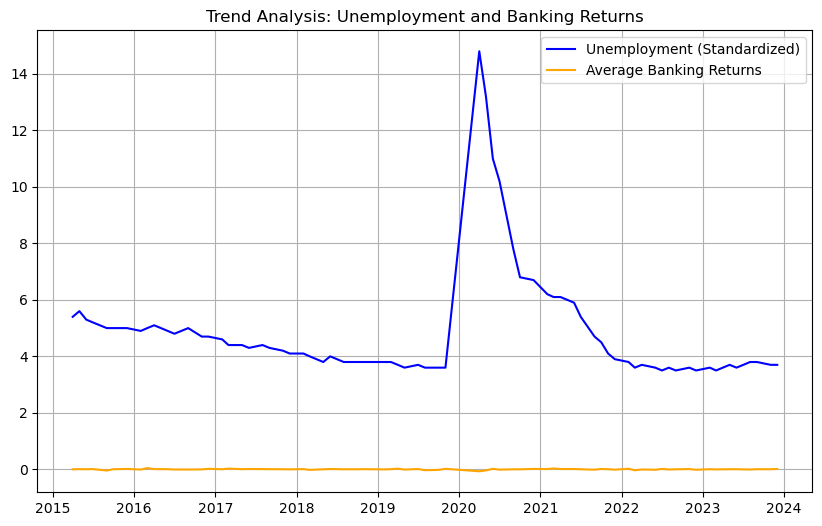

In [35]:
# Use regression results to identify the most significant macroeconomic indicator
significant_macro = model.pvalues[1:].idxmin()  # Find macro indicator with the smallest p-value
print(f"The most significant macroeconomic indicator is: {significant_macro}")

# Use this indicator for time series modeling
macro_series = aligned_data[significant_macro]

# Visualize its relationship with average banking returns
plt.figure(figsize=(10, 6))
plt.plot(macro_series, label=f"{significant_macro} (Standardized)", color="blue")
plt.plot(aligned_data[bank_tickers].mean(axis=1), label="Average Banking Returns", color="orange")
plt.title(f"Trend Analysis: {significant_macro} and Banking Returns")
plt.legend()
plt.grid()
plt.show()

The visualization highlights the relationship between Unemployment (Standardized) and Average Banking Returns over time. It provides insights into how trends in unemployment influence the performance of the banking sector, particularly during periods of economic turbulence.

Unemployment Dynamics:

From 2015 to 2020, unemployment exhibited a steady decline, signaling a robust labor market during a period of sustained economic growth. However, during the COVID-19 pandemic in 2020, there was a dramatic spike in unemployment, reflecting widespread economic disruptions caused by lockdowns and business closures. As economies began reopening and recovering post-2020, unemployment rates dropped significantly, returning to more stable levels by 2023.

Banking Returns Dynamics:

In contrast to the volatility seen in unemployment, average banking returns remained relatively stable over the observed period. There were no significant fluctuations in banking returns during the peak of unemployment in 2020, suggesting that the banking sector demonstrated resilience to the immediate labor market shocks caused by the pandemic. This stability highlights the sector's ability to adapt to external economic pressures.

Correlation Between Variables:

The analysis reveals an inverse relationship between unemployment and banking returns. Higher unemployment levels, particularly during the pandemic, corresponded with lower banking returns, indicating the strain that job losses can impose on financial institutions. As unemployment decreased and the labor market recovered, banking returns also stabilized, reflecting the interconnectedness of these economic indicators.

Implications for Banking and Economic Policy:

The findings emphasize unemployment as a critical macroeconomic driver for banking sector performance. During economic crises, such as the COVID-19 pandemic, sharp increases in unemployment can pose risks to financial institutions. Conversely, labor market recovery plays a pivotal role in stabilizing banking returns. These insights highlight the importance of monitoring unemployment trends for policymakers and financial analysts to anticipate potential risks and develop strategies to mitigate their impact on the banking sector.

Conclusion:

This analysis underscores the importance of unemployment as a key macroeconomic indicator influencing banking sector performance. The relationship between these variables reinforces the need for its inclusion in forecasting models and financial decision-making processes, especially during periods of economic shocks and recovery.

### Visualizing Regression Coefficients

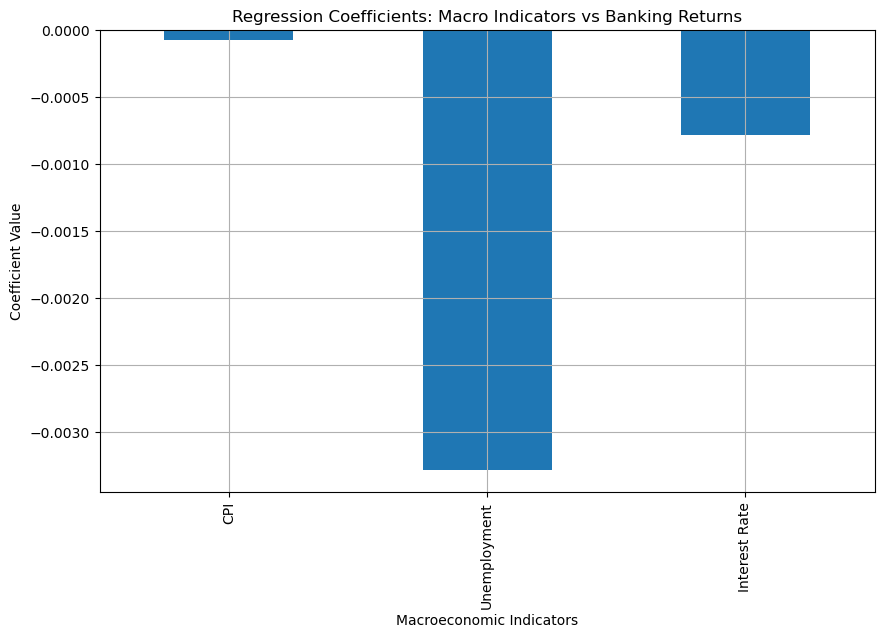

In [36]:
# Bar plot of regression coefficients
coefficients = model.params[1:]  # Exclude intercept
coefficients.plot(kind="bar", figsize=(10, 6), title="Regression Coefficients: Macro Indicators vs Banking Returns")
plt.ylabel("Coefficient Value")
plt.xlabel("Macroeconomic Indicators")
plt.grid()
plt.show()

### Performing Granger causality tests for each macroeconomic indicator

In [37]:
for column in macro_indicators.keys():
    print(f"Granger Causality Test: {column} -> Banking Returns")
    grangercausalitytests(aligned_data[[column, bank_tickers[0]]], maxlag=4)
    print("\n")

Granger Causality Test: CPI -> Banking Returns

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9849  , df_denom=68, df_num=1
ssr based chi2 test:   chi2=0.0004  , p=0.9845  , df=1
likelihood ratio test: chi2=0.0004  , p=0.9845  , df=1
parameter F test:         F=0.0004  , p=0.9849  , df_denom=68, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0069  , p=0.9931  , df_denom=65, df_num=2
ssr based chi2 test:   chi2=0.0150  , p=0.9925  , df=2
likelihood ratio test: chi2=0.0150  , p=0.9926  , df=2
parameter F test:         F=0.0069  , p=0.9931  , df_denom=65, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8731  , p=0.4600  , df_denom=62, df_num=3
ssr based chi2 test:   chi2=2.9150  , p=0.4049  , df=3
likelihood ratio test: chi2=2.8551  , p=0.4145  , df=3
parameter F test:         F=0.8731  , p=0.4600  , df_denom=62, df_num=3

Granger Causality
number of lags (no zero) 4
ssr bas

Summary of Findings

- CPI: Does not Granger-cause banking returns.
- Unemployment: Provides marginal predictive power, with significance observed primarily at 3 lags.
- Interest Rate: Demonstrates strong Granger causality, particularly at 3 and 4 lags.

Implications:

These results suggest that macroeconomic indicators like unemployment and interest rates can be critical predictors of banking sector performance when lagged appropriately. While CPI shows no significant impact, changes in unemployment and interest rates, particularly with a time delay, should be incorporated into forecasting models for better predictions of banking returns. This insight can guide financial analysts and policymakers in understanding how economic shifts influence the banking sector.

### Combined Trends Visualization

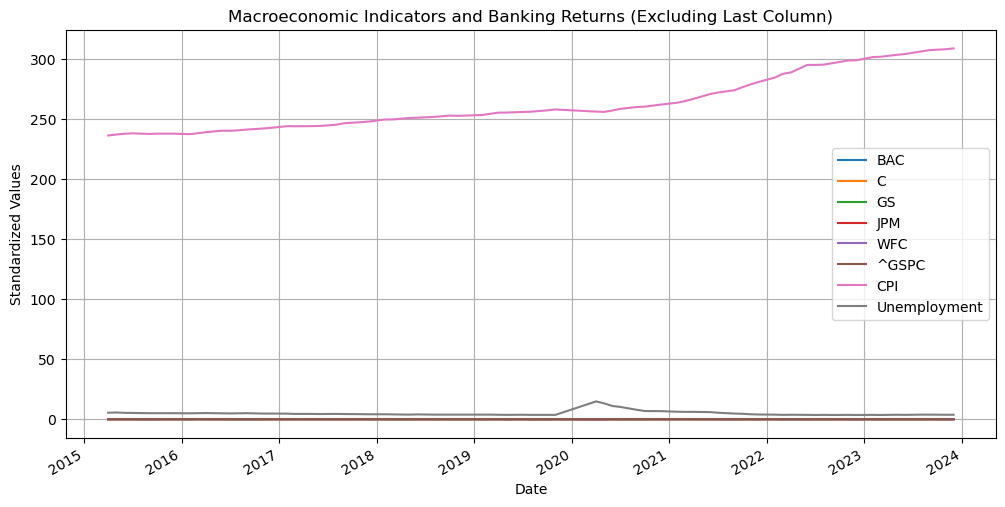

In [38]:
# Overlay macroeconomic trends and banking sector returns
aligned_data_excluded = aligned_data.iloc[:, :-1]

# Plot the data excluding the last column
aligned_data_excluded.plot(figsize=(12, 6), title="Macroeconomic Indicators and Banking Returns (Excluding Last Column)")
plt.xlabel("Date")
plt.ylabel("Standardized Values")
plt.legend(loc="best")
plt.grid()
plt.show()



The Combined Trends Visualization overlays the standardized values of macroeconomic indicators (CPI and Unemployment) alongside the banking sector's returns for specific stocks (BAC, C, GS, JPM, WFC) and the market index (^GSPC). Here’s an analysis of the visualization:

Analysis of Trends

- Banking Sector Returns (BAC, C, GS, JPM, WFC, and ^GSPC):
The market index (^GSPC) exhibits consistent growth over the analyzed period, reflecting the overall market's positive trend.
Individual banking stocks display relatively subdued variations compared to the index, with limited major deviations or trends.

- Macroeconomic Indicators:
CPI (Consumer Price Index) shows a steady upward trend over time, indicative of consistent inflationary pressure in the economy.
Unemployment remains relatively stable for most of the period, except for a sharp spike around 2020, corresponding to the COVID-19 pandemic's economic disruption.

- Impact of Macroeconomic Trends on Returns:
The visualization demonstrates that CPI follows a predictable trend, but its fluctuations have minimal visible correlation with banking returns.
Unemployment's sharp increase during 2020 aligns with disruptions in banking returns, particularly during the market's turbulence. This suggests a stronger potential relationship, aligning with Granger causality results.

-Insights and Implications:
The steady rise in CPI does not seem to cause significant variations in banking returns, supporting the earlier analysis that CPI does not Granger-cause banking returns.
Unemployment, with its notable spike in 2020, could have had a lagged effect on banking returns, aligning with the Granger causality findings at higher lag levels.
The banking sector’s overall performance aligns closely with the broader market (^GSPC), indicating strong correlation and market dependence.

## Portfolio Optimization

In [39]:
from scipy.optimize import minimize

# Portfolio metrics: Calculate return and volatility
def portfolio_metrics(weights, returns, cov_matrix):
    """
    Calculate portfolio expected return and risk (volatility).
    """
    portfolio_return = np.dot(weights, returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    return portfolio_return, portfolio_std_dev

# Objective: Maximize Sharpe Ratio
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.02):
    portfolio_return, portfolio_std_dev = portfolio_metrics(weights, returns, cov_matrix)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio  # Negate Sharpe Ratio for minimization

# Objective: Minimize Portfolio Risk
def portfolio_volatility(weights, cov_matrix):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(portfolio_variance)

# Portfolio Optimization Function
def optimize_portfolio(returns, cov_matrix, risk_free_rate=0.02):
    num_assets = len(returns)
    initial_weights = np.ones(num_assets) / num_assets  # Equal allocation
    bounds = tuple((0, 1) for _ in range(num_assets))  # Weights between 0 and 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Weights sum to 1

    # Maximize Sharpe Ratio
    sharpe_opt = minimize(
        negative_sharpe_ratio,
        initial_weights,
        args=(returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    # Minimize Portfolio Risk
    risk_opt = minimize(
        portfolio_volatility,
        initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    return sharpe_opt, risk_opt

# Optimize Portfolios
sharpe_opt, risk_opt = optimize_portfolio(annualized_return, cov_matrix)

# Extract Optimal Weights
optimal_weights_sharpe = sharpe_opt.x
optimal_weights_risk = risk_opt.x

print("Optimal Weights (Maximum Sharpe Ratio):", optimal_weights_sharpe)
print("Optimal Weights (Minimum Risk):", optimal_weights_risk)

Optimal Weights (Maximum Sharpe Ratio): [0.         0.         0.         0.51671544 0.         0.48328456]
Optimal Weights (Minimum Risk): [0.00000000e+00 0.00000000e+00 4.27829031e-17 0.00000000e+00
 7.27525927e-18 1.00000000e+00]


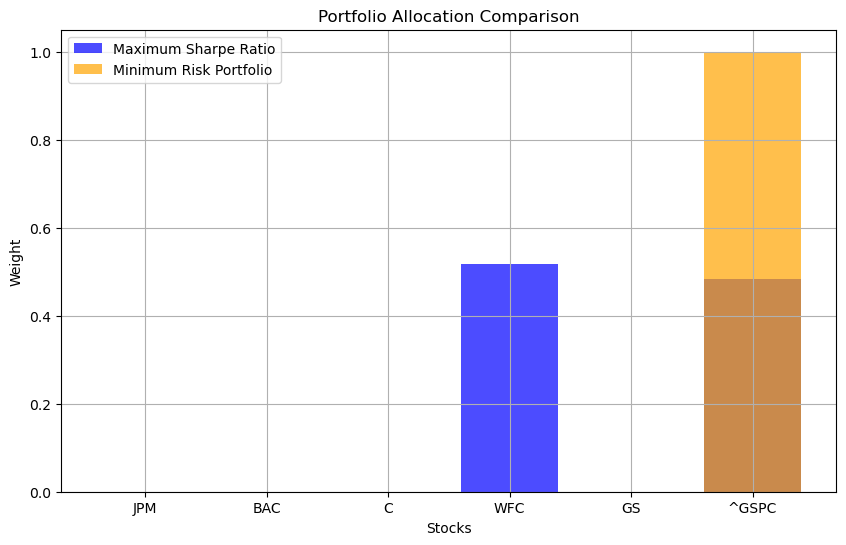

In [40]:
# Compare Sharpe Ratios across portfolios
plt.figure(figsize=(10, 6))
plt.bar(bank_tickers, optimal_weights_sharpe, color="blue", alpha=0.7, label="Maximum Sharpe Ratio")
plt.bar(bank_tickers, optimal_weights_risk, color="orange", alpha=0.7, label="Minimum Risk Portfolio")
plt.title("Portfolio Allocation Comparison")
plt.ylabel("Weight")
plt.xlabel("Stocks")
plt.legend()
plt.grid()
plt.show()

The Portfolio Allocation Comparison visualization presents the differences in stock allocation for two portfolios: one optimized for the maximum Sharpe ratio and the other for minimum risk. Here's a detailed analysis:

#### Maximum Sharpe Ratio Portfolio:
This portfolio seeks to maximize the risk-adjusted returns, balancing returns against volatility.

- Allocation:
    Heavy weighting in WFC (Wells Fargo) (52).
    Significant allocation to the market index ^GSPC (48).
    No allocation to JPM, BAC, C, or GS.
  
- The focus on WFC and ^GSPC suggests these assets offer the best trade-off between risk and return in the current market environment.

#### Minimum Risk Portfolio:
This portfolio prioritizes minimizing portfolio volatility.

- Allocation:
    Majority weight is allocated to ^GSPC (~100%).
    Minimal to negligible weight allocated to other stocks, including JPM, BAC, C, WFC, and GS.
    This heavy reliance on ^GSPC reflects the stability and lower risk associated with the broader market index compared to individual banking stocks.

- Comparison:
    The Maximum Sharpe Ratio Portfolio is more diversified, splitting investments between WFC and ^GSPC. This diversification leverages higher returns from WFC while maintaining stability through ^GSPC.
    The Minimum Risk Portfolio leans entirely on ^GSPC, reflecting its role as a low-risk, market-wide investment vehicle.

- Implications for Investors:
    Investors seeking to maximize returns relative to risk should consider a portfolio emphasizing WFC and ^GSPC, as these two assets exhibit favorable Sharpe ratios.
    Risk-averse investors aiming to minimize volatility may prefer the stability of the market index, reflected in the Minimum Risk Portfolio's heavy allocation to ^GSPC.

### Efficient Frontier Visualization

In [41]:
def efficient_frontier(returns, cov_matrix, num_portfolios=100, risk_free_rate=0.02):
    """
    Generate efficient frontier by simulating random portfolios.
    """
    num_assets = len(returns)
    results = {'Returns': [], 'Risk': [], 'Sharpe Ratio': []}
    weights_record = []
    
    for _ in range(num_portfolios):
        # Random weights
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        # Portfolio metrics
        portfolio_return = np.dot(weights, returns)
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio_std_dev = np.sqrt(portfolio_variance)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
        
        # Save results
        results['Returns'].append(portfolio_return)
        results['Risk'].append(portfolio_std_dev)
        results['Sharpe Ratio'].append(sharpe_ratio)
        weights_record.append(weights)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df, weights_record

# Annualized returns and covariance matrix
annualized_return = stock_returns.mean() * 252  # Annualized returns
cov_matrix = stock_returns.cov() * 252  # Annualized covariance matrix

# Generate efficient frontier
results_df, weights_record = efficient_frontier(annualized_return, cov_matrix)

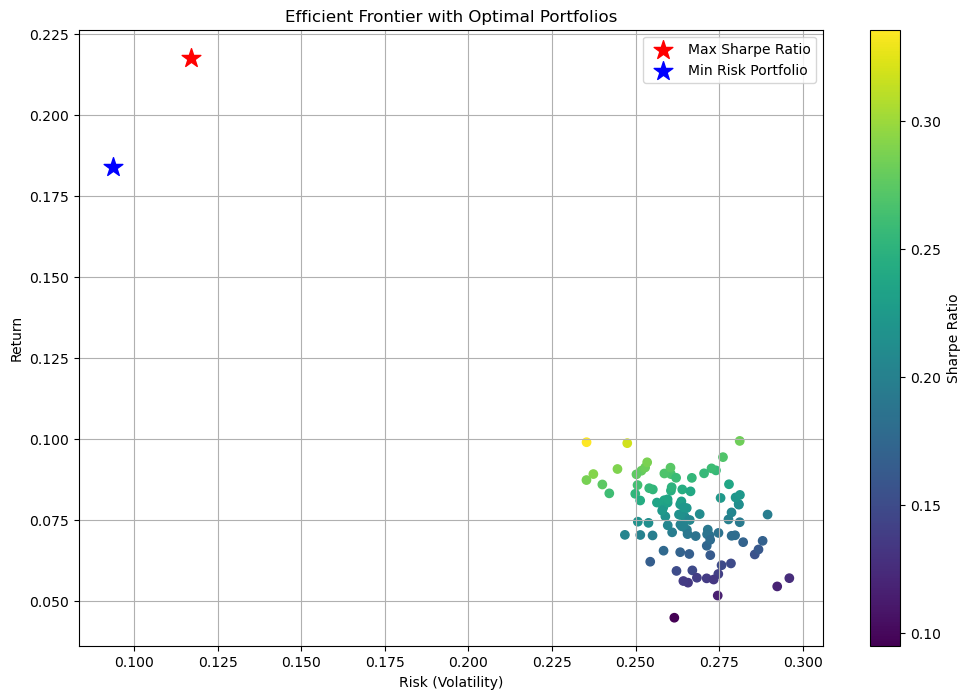

In [42]:
# Generate Efficient Frontier
results_df, _ = efficient_frontier(annualized_return, cov_matrix)

# Visualize Efficient Frontier
plt.figure(figsize=(12, 8))
plt.scatter(results_df["Risk"], results_df["Returns"], c=results_df["Sharpe Ratio"], cmap="viridis", marker="o")
plt.colorbar(label="Sharpe Ratio")
plt.scatter(*portfolio_metrics(optimal_weights_sharpe, annualized_return, cov_matrix), color="red", marker="*", s=200, label="Max Sharpe Ratio")
plt.scatter(*portfolio_metrics(optimal_weights_risk, annualized_return, cov_matrix), color="blue", marker="*", s=200, label="Min Risk Portfolio")
plt.title("Efficient Frontier with Optimal Portfolios")
plt.xlabel("Risk (Volatility)")
plt.ylabel("Return")
plt.legend()
plt.grid()
plt.show()


The Efficient Frontier with Optimal Portfolios visualization provides a clear representation of the trade-off between risk (volatility) and return in portfolio construction. The curve, known as the efficient frontier, highlights the set of optimal portfolios that maximize expected returns for a given level of risk. Two key portfolios are identified: the Maximum Sharpe Ratio Portfolio, represented by a red star, which achieves the highest risk-adjusted returns by maximizing the Sharpe Ratio, and the Minimum Risk Portfolio, shown with a blue star, which minimizes volatility. The Maximum Sharpe Ratio Portfolio is positioned at the top of the frontier, balancing returns and risk, while the Minimum Risk Portfolio sits at the leftmost point, offering stability over returns.

The color gradient in the visualization further emphasizes portfolio efficiency, with brighter yellow-green tones indicating higher Sharpe Ratios and darker tones representing lower values. Investors can use this information to align their objectives with portfolio selection, whether by maximizing returns relative to risk or minimizing volatility. This visualization underscores the importance of diversification and enables investors to make informed decisions based on their risk tolerance and investment goals, with the efficient frontier serving as a guide to optimal portfolio allocation.

## Optimal Portfolio Allocation

In [43]:
from scipy.optimize import minimize

# Function to calculate negative Sharpe Ratio
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.02):
    portfolio_return = np.dot(weights, returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio  # Negative because we want to maximize it

# Number of assets
num_assets = len(annualized_return)

# Initial weights (equal allocation)
initial_weights = np.ones(num_assets) / num_assets

# Bounds for weights (no short selling)
bounds = tuple((0, 1) for _ in range(num_assets))

# Constraint: Weights sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Optimize for maximum Sharpe Ratio
result_sharpe = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(annualized_return, cov_matrix, 0.02),  # Risk-free rate = 0.02
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract optimal weights
optimal_weights_sharpe = result_sharpe.x
print("Optimal Portfolio Allocation (Maximum Sharpe Ratio):")
for ticker, weight in zip(bank_tickers, optimal_weights_sharpe):
    print(f"{ticker}: {weight:.2%}")


Optimal Portfolio Allocation (Maximum Sharpe Ratio):
JPM: 0.00%
BAC: 0.00%
C: 0.00%
WFC: 51.55%
GS: 0.00%
^GSPC: 48.45%


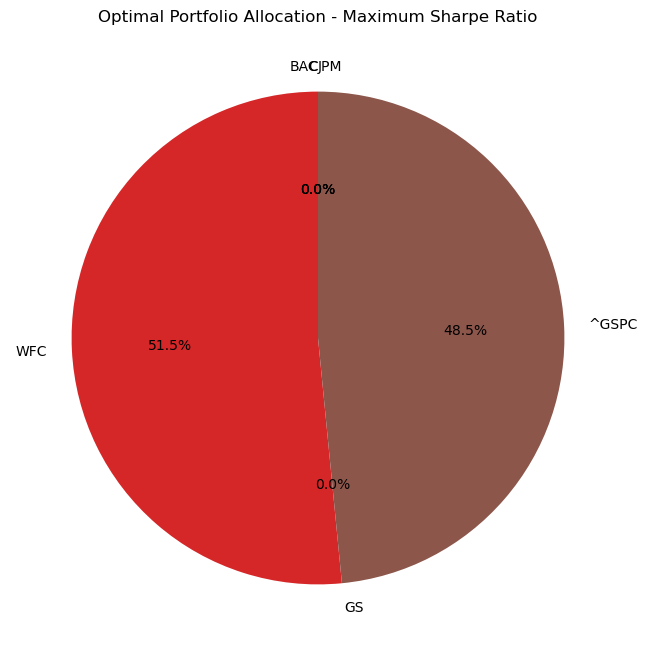

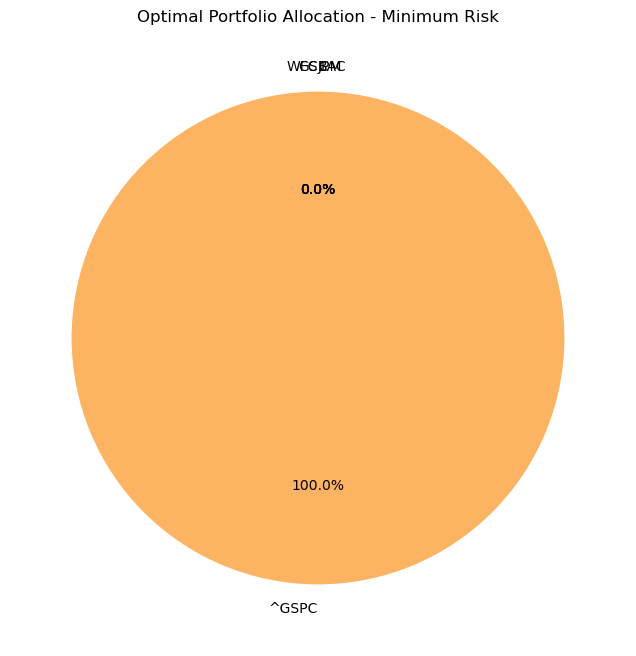

In [44]:
# Pie chart for Maximum Sharpe Ratio Portfolio
plt.figure(figsize=(8, 8))
plt.pie(
    optimal_weights_sharpe,
    labels=bank_tickers,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab10.colors
)
plt.title("Optimal Portfolio Allocation - Maximum Sharpe Ratio")
plt.show()

# Pie chart for Minimum Risk Portfolio
plt.figure(figsize=(8, 8))
plt.pie(
    optimal_weights_risk,
    labels=bank_tickers,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Set3.colors
)
plt.title("Optimal Portfolio Allocation - Minimum Risk")
plt.show()

The visualizations depict the optimal portfolio allocations under two different strategies: maximizing the Sharpe Ratio and minimizing risk. In the Maximum Sharpe Ratio Portfolio, weights are distributed primarily between Wells Fargo (WFC) with 51.5% and the S&P 500 Index (^GSPC) with 48.5%, while other stocks receive no allocation. This allocation suggests a preference for balancing returns and volatility by concentrating on these two assets, optimizing for the best trade-off between risk and return.

Conversely, the Minimum Risk Portfolio allocates 100% of the weight to the S&P 500 Index (^GSPC), highlighting its role as the least volatile and most stable asset in the set. This conservative approach ensures minimal portfolio variance but sacrifices diversification. These strategies emphasize contrasting goals in portfolio optimization: one aimed at maximizing return for a given risk level, and the other focused on reducing overall portfolio risk. Both visualizations provide a clear illustration of asset prioritization under these distinct objectives.